In [379]:
import pandas, numpy, timeit
pandas.set_option('display.max_columns', None)
from statistics import mode
from fuzzywuzzy import fuzz, process
import warnings
warnings.filterwarnings('ignore')
import xgboost
from sklearn.model_selection import train_test_split
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

### Recode "main" TRR dataset, describing setting of force event

In [2]:
def reverse_collapse_dict(dct):
    """Reverse keys and values of a dictionary while collapsing multiple keys into a list.
    Input: dict 'dct' {key:value} where multiple keys share same value.
    Output: dict 'new' {value1:[key1, key2], value2:key3}"""
    new = {}
    keys = numpy.array(list(dct.keys()))
    vals = numpy.array(list(dct.values())) # order is maintained so that we can rebuild via numpy index
    for val in set(vals):
        inds = numpy.where(vals==val)[0].tolist() # len of inds is # of trr_ids we need in new dict
        if len(inds) == 1: # simple case of reversing dictionary
            new[val] = keys[inds][0] 
        elif len(inds) > 1: # complex case where we need to build a list first to facilitate dictionary reversal
            matches = [] 
            for ind in inds:
                matches.append(keys[ind])
            new[val] = matches
    return new

In [3]:
# Load TRRs whose co-occurrence is validated by address & datetime sort comparison
cf = pandas.read_excel('C:/Users/mason/OneDrive/Documents/CPD FOIA/output/event_matches.xlsx')
# datetime_event_id is new event ID that links together TRRs that co-occurred
trr_event_map = dict(zip(cf['trr_id'], cf['datetime_event_id']))
event_to_trrs = reverse_collapse_dict(trr_event_map)

In [4]:
# Load raw FOIA files
path = 'C:/Users/mason/OneDrive/Documents/CPD FOIA/raw data/'
# "main"
df = pandas.read_excel(path+'P10655-FOIA-P046360-TRRdata.xlsx')
df.columns = df.columns.str.lower()
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df['event_id'] = df.trr_report_id.map(trr_event_map)

In [5]:
# Clean, recode
df['date'] = df['dte'].astype(str)
df['time'] = df['tmemil'].astype(str).str.zfill(4)
df['datetime'] = pandas.to_datetime(df['date'] + ' ' + df['time'])
df['dir'] = df['dir'].fillna(' ')
df['address'] = (df['blk'] + ' ' + df['dir'].str[0] + ' ' + df['stn']).str.lower()
df['street'] = (df['dir'].str[0] + ' ' + df['stn']).str.lower()
df['location'] = df['loc'].str.lower()
df['rd_no'] = df['rd_no'].str.replace('-','')
df['rd_no'] = df['rd_no'].str.replace(' ','')
df['rd_no'] = df['rd_no'].replace('DNA',numpy.nan)
df['rd_no'] = df['rd_no'].replace('NONE',numpy.nan)
df['officer_name'] = df['pofirst'].str.lower() + ' ' + df['polast'].str.lower()
df['subject_cb_no'] = df['subject_cb_no'].replace({0:numpy.nan,12345678:numpy.nan,99999999:numpy.nan,\
                                                  11111111:numpy.nan,1:numpy.nan}) # filler values

# Rename/drop columns that were recoded
rename = {'trr_report_id':'trr_id','subject_cb_no':'subj_id'}
df = df.rename(columns=rename)
to_delete = ['cr_no_obtained','dte','tmemil','notify_oemc','notify_dist_sergeant','notify_op_command','notify_det_div',\
             'number_of_weapons_discharged','pofirst','polast','pogndr','porace','poage','appointed_date','unitassg',
             'unitdetail','assgnbeat','rank','dutystatus','member_in_uniform','subgndr','subrace','subage','subyeardob',
             'date','time','blk','dir','loc','street']
for col in to_delete:
    del df[col]
    
# Fix "ave" typo (av)
avs = df[df['stn'].str.contains(' AV')].trr_id.tolist()
aves = df[df['stn'].str.contains(' AVE')].trr_id.tolist()
avs_only = [x for x in avs if x not in aves]
for trr in avs_only:
    ind = df[df['trr_id']==trr].index.values[0]
    current_address =  df.loc[ind, 'address']
    new_address = current_address.replace(' av',' ave')
    df.loc[ind, 'address'] = new_address
del df['stn']

### Actions-Responses - recode, deepen feature space

In [6]:
# Actions-Responses recode (need to run if merging to main)
ar = pandas.read_excel(path+'P10655-FOIA-P046360-TRRdata.xlsx', sheet_name='ActionsResponses')
ar.columns = ar.columns.str.lower()
ar = ar.applymap(lambda x: x.lower() if isinstance(x, str) else x)
ar['person'] = ar['person'].replace({'member action':'officer','subject action':'subject'})
ar = ar.rename(columns={'resistance type':'resistance_type'})

# Collapse 'action' & 'otherdescr' fields
ar['action'] = ar['action'].replace({'other (specify)':numpy.nan})
ar['action'] = ar['action'].fillna(ar['otherdescr'])
del ar['otherdescr']

In [7]:
# Split for convenience of investigation
oar = ar[ar['person']=='officer']
sar = ar[ar['person']=='subject']

# Quantify resistance levels (based on CPD Force Options Model)
resistance_map = {'passive resister':1,'active resister':2,'assailant assault':3,'assailant assault/battery':3,\
                  'assailant battery':3,'assailant deadly force':4}
sar['resist_level'] = sar['resistance_type'].map(resistance_map).fillna(ar['resistance_type'])

### Officer force types & levels, recode

In [8]:
# Officer Actions - recode, quantify
# 1) collapse/recode 'other (specify)' en masse into the action-boxes they naturally fit in
oar['action'] = oar['action'].str.replace('tazer','taser')
keywords = {}
keywords['presence'] = ['announced office','full uniform','announce office','displayed star','emergency lights',\
                       'produced police star','emergency veh. apparatus on','announced his office','member presence',\
                       'emer. lights','identified self as police','memebrs prescence','members presence',"member's presence"]
keywords['verbal'] = ['told','ordered','verbal','put your hands behind your','place arms behind back','stop resisting',\
                     'multiple warnings','asap','placed out arm, stating "stop"','negotiations','waited for','vernal',\
                     'voice commands','plead with','step back']
keywords['self_protect'] = ['jumped out of way','retreat','step away','created distance','took cover','jumped out of the way',\
                   'moved out of the way','moved out of way','distance & shielding','sidestepped vehicle','maintain cover',\
                           'blocked strike with forearm','stepped back','defens','moved','avoid','disarm','backed away',\
                           'take cover','sought cover','create distance','get subject off back','to defend',\
                            'knocked hand away','to block','movement and cover','move out of','distanc','physical seperation',\
                           'took evasive action','clear out of way','blocking','block','jumped away','evasive action',\
                           'jumped out of', 'of way','evasive driving & route change','rolled off the vehicle','deflected',\
                           'broke window to free arm','prepared self for impact','backed from offender','drive away',\
                           'of the way','raised arms','evasive','closed door to room','dove from path of vehicle',\
                           'maneuvered around','seeked cover','struck r/o with vehicle','phisically dusarm assailant',\
                           'r/o shot attcking dog','dodge','stepped away','extended arm to keep off. away','stiff arm'\
                            'gripped arm to remove weapon','tried to cover face','attempted to deflect','straight arm']
keywords['pursuit'] = ['chase','pursuit','pursue','hanged','forced door','approach','broke vehicle window','entry team formed',\
                      'closed in','followed vehicle','stopped in front of offender','offender walked away',\
                       'attempted to disable vehicle','fled','followed','persued offender','on foot','attempted to open',\
                      'approahced subject']
keywords['hold'] = ['hold','held','placed hand','arm bar','wrist lock','wristlock','restrain',\
                    'contain','physical control','pull','carried','carry','grab','sat no',\
                    'pinned','picked up','restrain','immobilize','subdue','push','drag',\
                    'securing','body weight','placed arm behind back','pin','headlock','head lock','bear hug','control body',\
                   'leg shackles','fought with subject on ground','hand check','hands','hair control','gained control',\
                   'controlling knee','shackeled ankles','control techniques','escort','gain control','shove',\
                    'forced into wagon','armbar','control  ','placed knee','struggle with subject','knee on','head control',\
                   'forced subject to the ground','forced into squad car','attempted to control','handcuff','cuff',\
                   'sat on','leg irons','extracted offender from closet','struggle','three point kneel','arm lock',\
                   'fell to ground','overpowered w/assist','wristbar','kneeled on back','forced arms behind back',\
                    'officers pryed arms open','lock','knelt','ankle shackles','3 point kneel','placed offender against car',\
                   'lifted offender from sidewalk','knee to back','secured to hospital bed','attempted to extend arm',\
                   'secured offenders legs','controlled legs','brought under control','placed back in padded cell',\
                   'seperation of offender& victim','overpower','secured against squad car','forced arms','control of arm',\
                   'prevent ingesting narcotics','attempted to secure','3-point',\
                    'extracted through window','kneeled on subject','placed into cell','kneeled on leg','smothering',\
                    'bodyweight','knee placed','shackles','leg-irons','shackling','firm grip']
keywords['compliance'] = ['pressure','joint manipulation','control tactics','used elbow','pain compliance',\
                          'control force tactics','foot on subject for control','presure','maintained control','put weight on',\
                         'control instrument','control technique']
keywords['pepper_spray'] = ['chemical','o/c','o.c.','pepper spray','oc release','deployed oc','oc discharge','o.c discharge',\
                           'oc spray','discharged oc','o.c','o c spray','spray']
keywords['stun'] = ['open hand strike','diffused','opnhnd strk','open hand','opened hand strike','palm strike',\
                    'forearm strike','stun tactics','stunning','stun to','head stun','stuns to','stun over','stun strike',\
                   'forearm stun','crainal stun','stun blow','stunt']
keywords['takedown'] = ['tackle','take down','wrestle','leg sweep','take-down','takedown','took subject down','take to ground',\
                       'taken to ground','rearward trip','emergency take','hip throw','taken down for officer safety',\
                       'hip toss','tripped', 'forced offender to floor','forced offender to the floor','took offender down',\
                       'swept with foot']
keywords['arrest'] = ['placed into custody','placed in custody','taken into custody','placed under arrest',\
                     'placed offender into custody','into custody','attempt to arrest','in custody','arrest',\
                      'custody w/o incident','custody w/out incident','detain','shut squad door','cage car',\
                      'squadrol transport','placing offen in car','placing ofen in car','closed squad car door',\
                      'placed into squadrol','assisted subject into vehicle','attempted to apprehend','lifted legs',\
                     'placing subject in the wagon','attempted to place in vehicle','placed into squadcar',\
                      'placed into vehicle','units placed subject in','closed squadrol door']
keywords['canine'] = ['canine','k-9']
keywords['direct_mechanical'] = ['closed hand','closed fist','kicks','kicked','kick to','punch','elbow strike','headbutt',\
                                 'direct mechanic','hand to hand combat','srikes','direct body mechanics','strike to face',\
                                 'to the assailants chest area','knee strike','direct mechannical','impact munition']
keywords['baton'] = ['baton','asp','hit with','night stk','night stick','cpd radio as impact weapon','flashlight',\
                     'impact weapon','struck with duty weapon','bicycle','ramming equipment','used stationary objects',\
                    'police radio','less lethal shotgun','strike with radio']
keywords['display_firearm'] = ['drew weapon','display only','firearm drawn','display weapon','displayed weapon','drew firearm'\
                             'displayed firearm','drew firearm','displayed firearm','drew duty weapon','firearm unholstered',
                             'weapon displayed','displayed duty weapon','unholstered weapon','weapon drawn','drew his weapon',\
                             'drawing weapon','displayed handgun','pointed weapon','weapon shown',"displayed member's firearm",\
                             'displayed sidearm','display of weapon','weapon pointed','draw weapon','pointed firearm',\
                             'drew service weapon','display of duty weapon','displayed service weapon','unholstered firearm',\
                             'raised firearm','pointed handgun',"displayed p.o.'s weapon'",'drawn weapon',\
                             "displayed p.o.'s weapon",'point handgun','aimed handgun','aim handgun','drew sidearm',\
                              'display firearm','drawn firearm']
keywords['other_deadly'] = ['choke','police vehicle','attempted to curb vehicle','used vehicle to stop off',\
                            'struck assailant with vehicle']
keywords['firearm'] = ['return fire','returned fire','shot at dog','discharged weapon',\
                       'deadly force','struggle to retain weapon','used firearm to destroy dog','discharge firearm',\
                      'accidential discharge','other (specify) firearm','unintentional discharge','returned fire',\
                      'firearm weapon discharge','firearm weapon discharge/destroy dog','firearm firearm',\
                      'firearm discharged firearm','discharge of firearm','in fear of life fired','fired at offender',\
                      'fired at attacking dog','in fear of life r/o fired','fired firearm','fired one','fired two',\
                      'fired handgun','fired weapon','fired in fear','shot fired','fired shot','fired at assailant',\
                       'discharged firearm']
keywords['firearm_dog'] = ['discharged weapon at dog','weapon discharge/destroy dog','animal destruction']
keywords['none'] = ['none','dna','does not apply','used no force','no action','charged accordingly','no contact',\
                   'unable to respond','notified oec','partner discharged','unable to contact subject',\
                    "redirected off's attempt",'no force necessary','see lazauskas trr','no other action taken by r/o',\
                   'refer to add.information','medical treatment for offender','see remarks','xx','no force used',\
                   'additional charges filed','see case report','a/o was driving','in additional information','see addl info',\
                   'no use of force','attack stopped by other p.o.']
keywords['missing'] = ['see narrative','see additonal information','see below','see additional info','see additional',\
                      'see add info','see comments','see assailant response','see box below','unk','add info']
keywords['911'] = ['called 911','dialed 911','emergency equipment','call 911','911','called police']
keywords['backup'] = ['requested assistance','requested back-up','called for assist','called for swat','10-1',\
                      'officers incapacitated','called for backup','signaled enforcement car','called for back up',\
                     'gave direction of flight','contacted cpd']
keywords['assisting'] = ['assisting officers','partner assistance','p.o. assistance','po assistance','requested back',\
                        'requested assist','call for assistance','p/o assistance','assistance','assisting officer']
keywords['possible error'] = ['no response','ignored threats','officer knocked to ground','fell to the ground',\
                              'fled p.o. un armed','turning to release off. grip','assist other officers']
keywords['vague'] = ['same use of force as resister']
keywords['unclear'] = ['psa used']
keywords['taser_display'] = ['taser (laser targeted)','taser (spark displayed)','display taser',\
                             'display taser','taser drawn','no probe contact','unholstered taser','taser displayed']
keywords['taser_probe'] = ['taser (probe discharge)','taser probe deployment','tased','one probe struck','one probe stuck',\
                          'deployed taser','probe discharge','taser deployed','taser was used','taser deployment',\
                           'depolyed taser','taser discharge','taser']
keywords['taser_stun'] = ['taser (contact stun)','no probe discharge','dry tased','2 cycles','arc 1 sec additional','tasered',\
                          'used taser','taser used','use of taser','taser arching','taser pulse','taser arc','contact stun',\
                         'dry stun','stun only']

In [9]:
# "officer_force" variable to deepen feature space beyond CPD Force Options levels 1-4
def convert_action(value):
    """Recode officer actions into coarser force actions so model can learn from actual techniques beyond levels 1-4"""
    if value=='firearm':
        return('firearm')
    elif value=='other (specify)':
        return('missing')
    else:
        value = value.replace('other (specify) ','')
        value = value.replace('other (specify)','')
    hits = []
    for action in keywords:
        for keyword in keywords[action]:
            if keyword in value:
                hits.append(action)
    if hits != []:
        h = list(set(hits))
        out = ', '.join(h)
        return(out)

oar['action_coarse'] = oar['action'].apply(convert_action)

# Quantify officer force level (CPD Force Options Model)
quantify_force_level = {'none':0,'missing':0,'vague':0,'unclear':0,'911':0,'assisting':0,'backup':0,'possible error':0,\
                        'verbal':0,'presence':0,'self_protect':0,'pursuit':0,'hold':1,'arrest':1,'taser_display':1,\
                        'display_firearm':1,'compliance':1,'takedown':2,'stun':2,'taser_stun':2,'taser_probe':2,'canine':2,\
                        'pepper_spray':2,'take down/emergency handcuffing':2,'direct_mechanical':3,'baton':3,'lethal':4,\
                        'firearm':4,'other_deadly':4,'firearm_dog':4}
oar['force_level'] = oar['action_coarse'].map(quantify_force_level)

def force_level_from_multiple(officer_force):
    if type(officer_force) == str:
        if ',' in officer_force:
            forces = officer_force.split(', ')
            levels = [quantify_force_level[x] for x in forces]
            return(max(levels))
        else:
            return(officer_force)

oar['force_level'] = oar['force_level'].fillna(oar['action_coarse'].apply(force_level_from_multiple))

### Subject force actions

In [9]:
# other (specify) subject actions result from forced choice on TRR input form
#     fill in force_level with "resistance_level.X", e.g., 2.X
# old implementation is slow - come back to this (don't waste time on it now given you may not end up needing to do it)
# new implementation (unfinished) below
#sal = sar['resist_level']
#sals = sar['subj_action_level']
#sals = sals.fillna('X')

# # "action" field is forced-choice (different options for officer vs. subject actions)
# 47,835 (9%) 'action' fields overall are "other (specify)"; almost every record has 'otherdescr' filled
# exception: 3 records where both 'action' and 'otherdescr' are missing: TRRs 16563 (alone), 68573 (alone), 
# 90879 (90878 also in event)
# deal with this later
#na = ar[pandas.isnull(ar['action'])]
#no = ar[pandas.isnull(ar['otherdescr'])]
#nao = na[pandas.isnull(ar['otherdescr'])]

In [10]:
# clean rerun
sar = ar[ar['person']=='subject']
sar['resist_level'] = sar['resistance_type'].map(resistance_map).fillna(ar['resistance_type'])

In [11]:
# 1) Quantify severity of subject actions on force continuum (more granular than resistance level)
action_map = {'did not follow verbal direction':1, 'stiffened (dead weight)':1.5,\
             'pulled away':2, 'fled':2.5,'imminent threat of battery':3,'attack without weapon':3.5,\
              'attack with weapon':3.75,'uses force likely to cause death or great bodily harm':4,\
              'weapon(describe in additional info)':4, '':'X'}
sar['force_level'] = sar['action'].map(action_map)

In [44]:
#(sar[sar['action'].str.contains('drop')].action.value_counts()).to_dict()

In [12]:
# Subject Actions - recode other (please specify)
sar.loc[344460,'action'] = 'uses force likely to cause death or great bodily harm' # only missing value fixed manually
s_key = {}
s_key['did not follow verbal direction'] = ['refused to exit vehicle','refused to show hands']
s_key['stiffened (dead weight)'] = ['stiffened arms','locked arms','twist','dropp']
s_key['pulled away'] = ['flail','refused to be handcuffed','swinging arms','swung','swung body',\
                        'refused to be cuffed','resist','struggled','swinging','swing']
s_key['recode_needed'] = ['see below','see additional','',' ','see additional','see narrative']
s_key['uses force likely to cause death or great bodily harm'] = ['uses force likely to cause death or great bodily harm ',\
                                                                  'used vehicle as weapon','knife','motor vehicle',\
                                                                 'pointed handgun','firearm','threatened to kill']
s_key['imminent threat of battery'] = ['clenched','clinched','fighting stance','balled','became combative',\
                                       'combative','verbal threat','verbal assault','refused to drop']
s_key['fled'] = ['attempted to flee']
s_key['attack without weapon'] = ['kicking','kicked','pushed','spit','hands and feet','punch','attempted to bite',\
                                 'bit','attempted to disarm','teeth','struck','battery','elbow','closed fist','fist','hand,fist']
#s_key['attack_with_weapon'] = 

def convert_subject_action(value):
    hits = []
    for action in s_key:
        for keyword in s_key[action]:
            if keyword in value:
                if action != 'recode_needed':
                    hits.append(action)
    if len(hits)==1:
        return hits[0]
    if hits != []:
        h = list(set(hits))
        out = ', '.join(h)
        return(out)

In [248]:
convert_subject_action('see additional information')

In [13]:
sar['action_coarse'] = sar['action'].apply(lambda x: x if x in action_map else numpy.nan)
sar['action_coarse'] = sar['action_coarse'].fillna(sar['action'].apply(convert_subject_action))
#sar['action_coarse'] = sar['action_coarse'].fillna(sar['action']) # need to handle commas
sar['force_level'] = sar['action_coarse'].map(action_map)
#sar['force_level'] = sar['force_level'].fillna(sar['action_coarse'].map(action_map))
sar['force_level'].isna().sum()

16813

In [14]:
subj_actions_exact = {}
subj_actions_exact['hands'] = 'attack without weapon'
subj_actions_exact['feet'] = 'attack without weapon'
subj_actions_exact['flailed arms and kicked legs'] = 'pulled away'
subj_actions_exact['verbal threat of battery of po'] = 'imminent threat of battery'
sar['action_coarse'] = sar['action_coarse'].fillna(sar['action'].map(subj_actions_exact))
sar['force_level'] = sar['action_coarse'].map(action_map)
#sar['action_coarse'] = sar['force_level'].fillna(sar['action_coarse'].map(action_map))
ambiguous = ['vehicle',' ',]
sar['force_level'].isna().sum()

16697

In [311]:
#sarn = sar[sar['action_coarse'].notna()]
#sarn[sarn['action_coarse'].str.contains(',')]

In [15]:
def subj_force_level_from_multiple(subject_force):
    if type(subject_force) == str:
        if ',' in subject_force:
            forces = subject_force.split(', ')
            levels = [action_map[x] for x in forces]
            return(max(levels))
        else:
            return(subject_force)
sar['force_level'] = sar['force_level'].fillna(sar['action_coarse'].apply(subj_force_level_from_multiple))

In [253]:
subj_actions_exact['flailed arms and kicked legs']

'pulled away'

In [50]:
(sar[pandas.isnull(sar['force_level'])].action.value_counts()).to_dict()

{'clenched fists': 185,
 'vehicle': 163,
 'see additional information': 83,
 'clenched fist': 76,
 'see below': 72,
 'see additional info': 57,
 'clinched fists': 52,
 'see narrative': 52,
 'clinched fist': 51,
 ' ': 49,
 'flailed arms and kicked legs': 37,
 'walked away': 33,
 'see additional info box': 29,
 'verbally abusive': 28,
 'flayed arms': 26,
 'flailed arms, kicked legs': 25,
 'threatened officer': 25,
 'attempt to flee': 24,
 'swinging arms and kicking': 22,
 'handgun': 22,
 'head butt': 21,
 'dna': 21,
 'charged at officer': 21,
 'kicking and flailing arms': 21,
 'attempted to defeat arrest': 20,
 'spat on officer': 19,
 'kicked and flailed arms': 19,
 'hands/feet': 19,
 'flailing arms and kicking legs': 19,
 'kick': 18,
 'attempted to kick r/o': 17,
 'balled up fists': 17,
 'flailed arms and kicked': 16,
 'verbally threatened': 16,
 'swung with closed fist': 15,
 'open hand strike': 15,
 'clenched fists ': 15,
 'kicking and swinging arms': 15,
 'fled in vehicle': 15,
 'ref

In [190]:
sar[pandas.isnull(sar['force_level'])]

,trr_report_id,person,resistance_type,action,resist_level,action_coarse,force_level
170,38,subject,active resister,attempted to kick,2,attempted to kick,NaN
181,39,subject,assailant battery,"hand,fist",3,"hand,fist",NaN
395,94,subject,assailant assault,told dog to attack,3,told dog to attack,NaN
449,101,subject,assailant battery,swung arms and kicked legs,3,"attack without weapon, pulled away",NaN
459,102,subject,assailant battery,"flailing arms,kicking",3,"attack without weapon, pulled away",NaN
...,...,...,...,...,...,...,...
522773,96393,subject,active resister,stiffened to prevent cuffing,2,stiffened to prevent cuffing,NaN
522817,96403,subject,assailant battery,shoes,3,shoes,NaN
522875,96410,subject,active resister,attempt to defeat being handcu,2,attempt to defeat being handcu,NaN
523001,96439,subject,assailant battery,student fight,3,student fight,NaN


In [16]:
# missingness situation - 20% of TRRs have NaN force_level
sar.isna().sum() / len(sar)
na_fl_trrs = sar[pandas.isnull(sar['force_level'])].trr_report_id.unique().tolist()
len(na_fl_trrs) / len(sar.trr_report_id.unique().tolist())

0.1760639092130805

### Combine officer + subject force actions

In [16]:
af = pandas.concat([oar,sar])
af = af.rename(columns={'trr_report_id':'trr_id'})
af['resist_level'] = af['resist_level'].fillna(af['resistance_type'].map(resistance_map))
#af['resist_level'] = af['resist_level'].fillna(af['resistance_type'].map(resistance_map)) now redundant
officer_actions = list(keywords.keys())
subject_actions = list(action_map.keys())
af['event_id'] = af['trr_id'].map(trr_event_map)
af = af[['event_id','trr_id','person','resistance_type','resist_level','force_level','action','action_coarse',]]
af = af.sort_values(by=['event_id','trr_id','resist_level','force_level'])

In [17]:
fln = af[pandas.isnull(af['force_level'])]
tn = fln.trr_id.unique().tolist()
print(len(tn) / len(af.trr_id.unique()), 'TRRs with a null action ')
en = fln.event_id.unique().tolist()
print(len(en) / len(af.event_id.unique()), 'Events with a null action')

0.1845501887580763 TRRs with a null action 
0.2324995152220283 Events with a null action


In [18]:
# Drop these for now
aa = af[~af['event_id'].isin(en)].reset_index(drop=True)

In [24]:
#aa[0:50]

### [optional] Merge "actions-responses" to "main" for legibility of event and its TRRs

In [25]:
# Merge
tr = df.merge(af, how='left',on='trr_id')
tr = tr.sort_values(by=['event_id_x','trr_id','force_level','person'], ascending=[True,True,True,False])
del tr['event_id_y']
tr = tr.rename(columns={'event_id_x':'event_id'})
tr.force_level = pandas.to_numeric(tr.force_level)
tr = tr.sort_values(by=['event_id','trr_id','resist_level','force_level']).reset_index(drop=True)
#del main['sr_no_x'],main['se_no_x'], main['date_time'], main['trr_time'], main['sr_no_y'], main['se_no_y'],\
#main['action_category']

#cols = main.columns.tolist()
#cols.insert(0, cols.pop(cols.index('event_id')))
#main['action_sub_category'] = main['action_sub_category'].fillna(0)
#trr = main[cols]
#trr = trr.reset_index(drop=True)

In [363]:
# export
tr.to_csv('C:/Users/mason/OneDrive/Documents/CPD FOIA/output/main_actions_responses.csv')
#tr[tr['event_id']==41257]

## Prediction - officer/subject injury (setting features only, no actions yet)

### Feature engineering!

In [19]:
orig = df.copy()
# 'location' descriptor
loc_collapse = {'street':'street','sidewalk':'sidewalk','residence':'residence','apartment':'apartment','alley':'alley',
                'other':'other','police facility/veh parking lot':'police_parking_lot',
                'residence porch/hallway':'residence_porch_hallway','residential yard (front/back)':'residence_yard',
                'parking lot/garage(non.resid.)':'parking_nonres','gas station':'gas_station','other':'other_location'}
df['location'] = df['location'].replace(loc_collapse)
# 
others = df[~df['location'].isin(loc_collapse.values())].location.unique().tolist()
print(len(others), 'unique location descriptors remain after recode - return to collapse these later')
replace_w_other = {x:'other_location' for x in others}
df['location'] = df['location'].replace(replace_w_other)
#(df.location.value_counts() / len(df)).to_dict()

79 unique location descriptors remain after recode - return to collapse these later


In [20]:
# recode features
binary = {'no':0,'yes':1}
for col in ['poinjured', 'subject_armed','subject_injured','subject_alleged_injury']:
    df[col] = df[col].replace(binary)

df['outdoor'] = (df['indoor_or_outdoor']=='outdoor').replace({True:1,False:0})
if 'indoor_or_outdoor' in df.columns:
    del df['indoor_or_outdoor']
    
# beats! spatio-temporal controls are powerful
df['beat'] = df['beat'].astype(str).str.zfill(4)
df['district'] = df['beat'].str[0:2]
# 305 unique beats
# 26 unique districts (1-25 are on map; not 31 and 41; 0 may be special assignment)

# setting
df['lighting_condition'] = df['lighting_condition'].replace({'good artificial':'good_artificial',
                                                             'poor artificial':'poor_artificial'})
df['weather_condition'] = df['weather_condition'].replace({'fog/smoke/haze':'fog_smoke_haze','sleet/hail':'sleet_hail',
                                                            'severe cross wind':'wind','other':'other_weather'})

In [21]:
# Dummies
light = pandas.get_dummies(df['lighting_condition'])
weather = pandas.get_dummies(df['weather_condition'])
location = pandas.get_dummies(df['location'])
district = pandas.get_dummies(df['district'], prefix='district')
ff = df[['poinjured','subject_armed','subject_injured','subject_alleged_injury','outdoor']]
ff = pandas.concat([ff,location,light,weather,district], axis=1)

In [145]:
# Dataframe + Feature Set
df_f = pandas.concat([df,location,light,weather,district], axis=1)
dff = dff[['event_id','trr_id','poinjured','subject_armed','subject_injured','subject_alleged_injury','outdoor','dawn','daylight','dusk',
        'good_artificial','poor_artificial','night','clear','fog_smoke_haze','other_weather','rain','sleet_hail','snow','wind','alley',
        'apartment','gas_station','other_location','parking_nonres','police_parking_lot','residence','residence_porch_hallway',
        'residence_yard','sidewalk','street']]

In [ ]:
# Feature set only
ff = ff[['poinjured','subject_armed','subject_injured','subject_alleged_injury','outdoor','dawn','daylight','dusk',
        'good_artificial','poor_artificial','night','clear','fog_smoke_haze','other_weather','rain','sleet_hail','snow','wind','alley',
        'apartment','gas_station','other_location','parking_nonres','police_parking_lot','residence','residence_porch_hallway',
        'residence_yard','sidewalk','street']]

### Decision Tree Classifier Fit

In [211]:
cls = xgboost.XGBClassifier(n_estimators=100, max_depth=0, early_stopping_rounds=4, grow_policy='lossguide')
# to vary: grow_policy (depthwise, lossguide)

In [ ]:
target = ff['poinjured']
feat_cols = [x for x in ff.columns.tolist() if x not in ['poinjured','subject_injured','subject_alleged_injury']]
feats = ff[feat_cols]
x_train, x_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=7)
dtrain = xgboost.DMatrix(x_train, label=y_train)
dtest = xgboost.DMatrix(x_test, label=y_test)
cls.fit(X=x_train, y=y_train, eval_set=[(x_test, y_test)])

In [248]:
cls.fit(X=x_train, y=y_train, eval_set=[(x_test, y_test)])
logloss = -numpy.log(.52803)

[0]	validation_0-logloss:0.53127
[1]	validation_0-logloss:0.52988
[2]	validation_0-logloss:0.52921
[3]	validation_0-logloss:0.52860
[4]	validation_0-logloss:0.52827
[5]	validation_0-logloss:0.52815
[6]	validation_0-logloss:0.52803
[7]	validation_0-logloss:0.52816
[8]	validation_0-logloss:0.52818
[9]	validation_0-logloss:0.52820
[10]	validation_0-logloss:0.52826
[11]	validation_0-logloss:0.52820
[12]	validation_0-logloss:0.52832
[13]	validation_0-logloss:0.52844
[14]	validation_0-logloss:0.52828
[15]	validation_0-logloss:0.52825
[16]	validation_0-logloss:0.52840
[17]	validation_0-logloss:0.52837
[18]	validation_0-logloss:0.52866
[19]	validation_0-logloss:0.52877
[20]	validation_0-logloss:0.52899
[21]	validation_0-logloss:0.52920
[22]	validation_0-logloss:0.52928
[23]	validation_0-logloss:0.52945
[24]	validation_0-logloss:0.52956
[25]	validation_0-logloss:0.52961
[26]	validation_0-logloss:0.52960
[27]	validation_0-logloss:0.52967
[28]	validation_0-logloss:0.52976
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [249]:
cls.feature_importances_

array([0.01532706, 0.01529453, 0.0179856 , 0.01345277, 0.01625234,
       0.01633264, 0.01551432, 0.01650679, 0.01503064, 0.02129721,
       0.01663344, 0.01406217, 0.01289994, 0.01174875, 0.01469981,
       0.01527277, 0.01510739, 0.01544749, 0.01558235, 0.01431599,
       0.0092417 , 0.01603632, 0.01484137, 0.00818584, 0.01734716,
       0.01181012, 0.01313616, 0.02411187, 0.02179838, 0.02168824,
       0.02490121, 0.01969133, 0.01747559, 0.02233364, 0.02525625,
       0.0270797 , 0.02578593, 0.0263971 , 0.01788433, 0.02202443,
       0.02129343, 0.03148126, 0.02463806, 0.01861916, 0.01842529,
       0.04525317, 0.02288859, 0.01824592, 0.02219363, 0.02725076,
       0.01751705, 0.02632565, 0.01007731, 0.        ], dtype=float32)

In [250]:
out = "C:/Users/mason/OneDrive/Documents/CPD FOIA/model fits/TRR level no actions/"
bst = cls.get_booster()
bst.dump_model(out+'trees.txt')#, out+'features.txt')

In [254]:
pred = cls.predict(feats)
explainer = shap.TreeExplainer(cls)
explanation = explainer(feats)

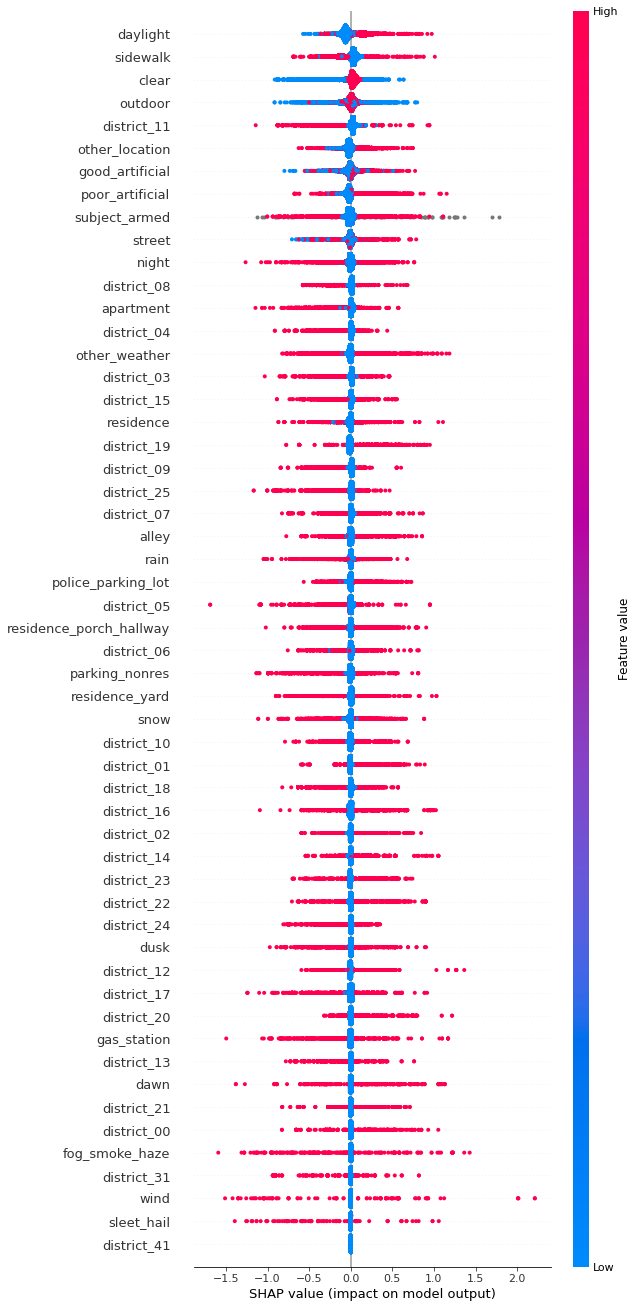

In [259]:
shap.plots.beeswarm(explanation, max_display=len(feats))

In [257]:
#xgboost.plot_tree(cls, num_trees=2)

In [ ]:
# event-level features: indoor/outdoor, lighting, weather, location (n=90, w/o collapse), beat (n=305 w/o collapse e.g. shapefiles)
# trr-level features (to be aggregated to event level): 
# outcomes: subject injury, subject alleged injury, officer injury (23%)

### Subject injury

In [14]:
scs = xgboost.XGBClassifier(n_estimators=100, max_depth=6, early_stopping_rounds=4, grow_policy='lossguide')
# to vary: grow_policy (depthwise, lossguide)

In [20]:
sy_train.isna().sum() / len(sy_train)

0.001063135316609158

In [23]:
sf = ff[[x for x in ff.columns.tolist() if x!='subject_alleged_injury']]
sf = sf.dropna()

In [25]:
# to vary: grow_policy (depthwise, lossguide)
stg = sf['subject_injured']
feat_cols = [x for x in ff.columns.tolist() if x not in ['poinjured','subject_injured','subject_alleged_injury']]
feats = sf[feat_cols]
s_train, s_test, sy_train, sy_test = train_test_split(feats, stg, test_size=0.2, random_state=7)
#dtrain = xgboost.DMatrix(x_train, label=y_train)
#dtest = xgboost.DMatrix(x_test, label=y_test)
scs.fit(X=s_train, y=sy_train, eval_set=[(s_test, sy_test)])

[0]	validation_0-logloss:0.57577
[1]	validation_0-logloss:0.57358
[2]	validation_0-logloss:0.57235
[3]	validation_0-logloss:0.57148
[4]	validation_0-logloss:0.57085
[5]	validation_0-logloss:0.57049
[6]	validation_0-logloss:0.56999
[7]	validation_0-logloss:0.56975
[8]	validation_0-logloss:0.56929
[9]	validation_0-logloss:0.56927
[10]	validation_0-logloss:0.56901
[11]	validation_0-logloss:0.56888
[12]	validation_0-logloss:0.56892
[13]	validation_0-logloss:0.56877
[14]	validation_0-logloss:0.56863
[15]	validation_0-logloss:0.56856
[16]	validation_0-logloss:0.56817
[17]	validation_0-logloss:0.56809
[18]	validation_0-logloss:0.56788
[19]	validation_0-logloss:0.56778
[20]	validation_0-logloss:0.56756
[21]	validation_0-logloss:0.56755
[22]	validation_0-logloss:0.56747
[23]	validation_0-logloss:0.56746
[24]	validation_0-logloss:0.56748
[25]	validation_0-logloss:0.56751
[26]	validation_0-logloss:0.56747
[27]	validation_0-logloss:0.56746
[28]	validation_0-logloss:0.56757
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=4,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
feat_cols = feats.columns.tolist()
pandas.DataFrame(data=scs.feature_importances_, index=feat_cols).sort_values(by=0,ascending=False)

,0
subject_armed,0.088775
district_14,0.046162
district_13,0.034708
district_09,0.029049
district_24,0.028166
alley,0.025766
residence_yard,0.024102
district_05,0.023626
district_12,0.022619
district_18,0.022272


In [41]:
out = "C:/Users/mason/OneDrive/Documents/CPD FOIA/model fits/TRR level no actions/"
sst = scs.get_booster()
sst.dump_model(out+'subject_injury_trees.txt')#, out+'features.txt')
pred = scs.predict(feats)
explainer = shap.TreeExplainer(sst)
explanation = explainer(feats)

In [516]:
pandas.DataFrame(data=scs.feature_importances_, index=feats.columns).sort_values(by=0, ascending=False)

,0
subject_armed,0.088775
district_14,0.046162
district_13,0.034708
district_09,0.029049
district_24,0.028166
alley,0.025766
residence_yard,0.024102
district_05,0.023626
district_12,0.022619
district_18,0.022272


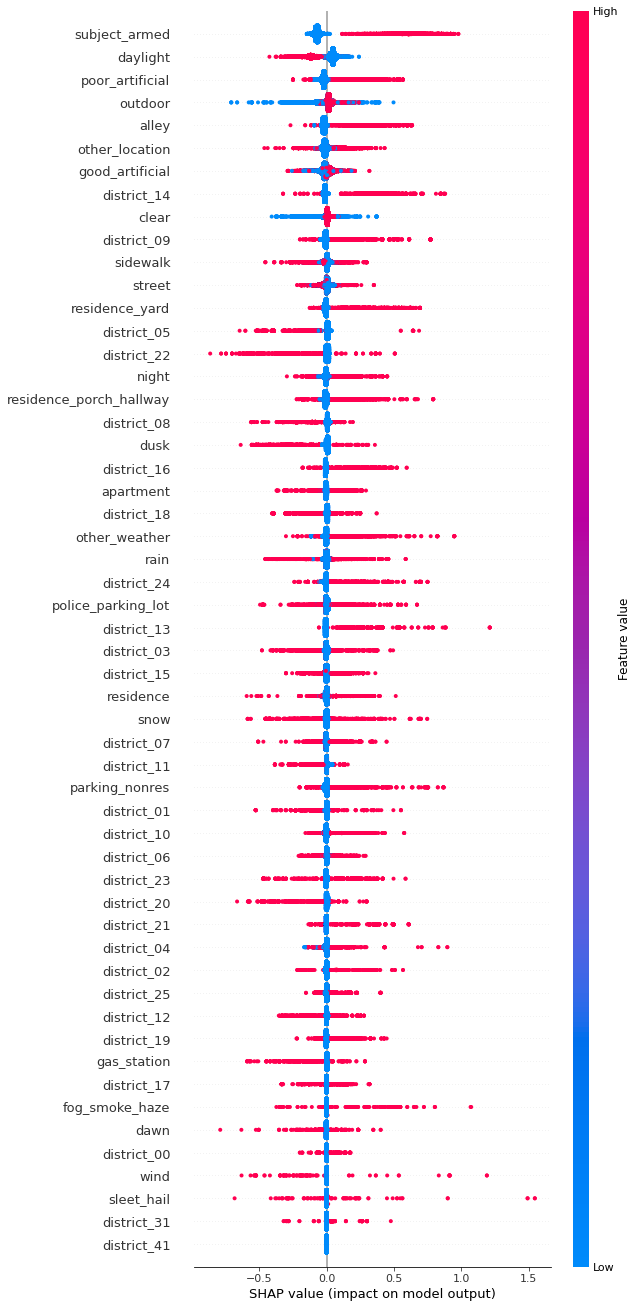

In [42]:
shap.plots.beeswarm(explanation, max_display=len(feats))

In [417]:
shap_interaction_values = explainer.shap_interaction_values(feats)
shap_interaction_values[0]

array([[-7.9612494e-02, -7.4587017e-04, -4.1939784e-05, ...,
         3.7599355e-05,  0.0000000e+00,  0.0000000e+00],
       [-7.4587576e-04,  2.0786729e-02,  6.2438194e-05, ...,
         1.0955522e-03,  0.0000000e+00,  0.0000000e+00],
       [-4.1943043e-05,  6.2435865e-05, -2.1972820e-02, ...,
         0.0000000e+00, -5.7945515e-05,  0.0000000e+00],
       ...,
       [ 3.7601218e-05,  1.0955520e-03,  0.0000000e+00, ...,
        -1.6063782e-03,  2.2849490e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -5.7945726e-05, ...,
         2.2849999e-06, -2.6730736e-04,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [ ]:
#numpy.savetxt('C:/Users/mason/OneDrive/Documents/CPD FOIA/output/subj_injury_shap_interactions.txt', shap_interaction_values)
shap_interaction_values.shape

In [495]:
# SHAP Interaction values above threshold (1%)
threshold = 0.01
interactions = []
for col in ms.columns.tolist():
    hits = ms[ms[col] > threshold].index.tolist()
    for hit in hits:
        if col != hit:
            val = round(ms.loc[hit,col], 5)
            if val not in interactions:
                #print(interactions)
                interactions.append(val)
                print(col,'x',hit, val)

subject_armed x sidewalk 0.0114
outdoor x other_location 0.01556
outdoor x police_parking_lot 0.01119
other_location x daylight 0.01344
street x good_artificial 0.01359


In [496]:
shap_interaction_values.shape

(66921, 54, 54)

In [504]:
shap_interaction_values[0].shape

(54, 54)

In [502]:
shap_interaction_values.mean()

-7.749281e-06

In [514]:
#pandas.DataFrame(shap_interaction_values[0],index=feats.columns, columns=feats.columns)

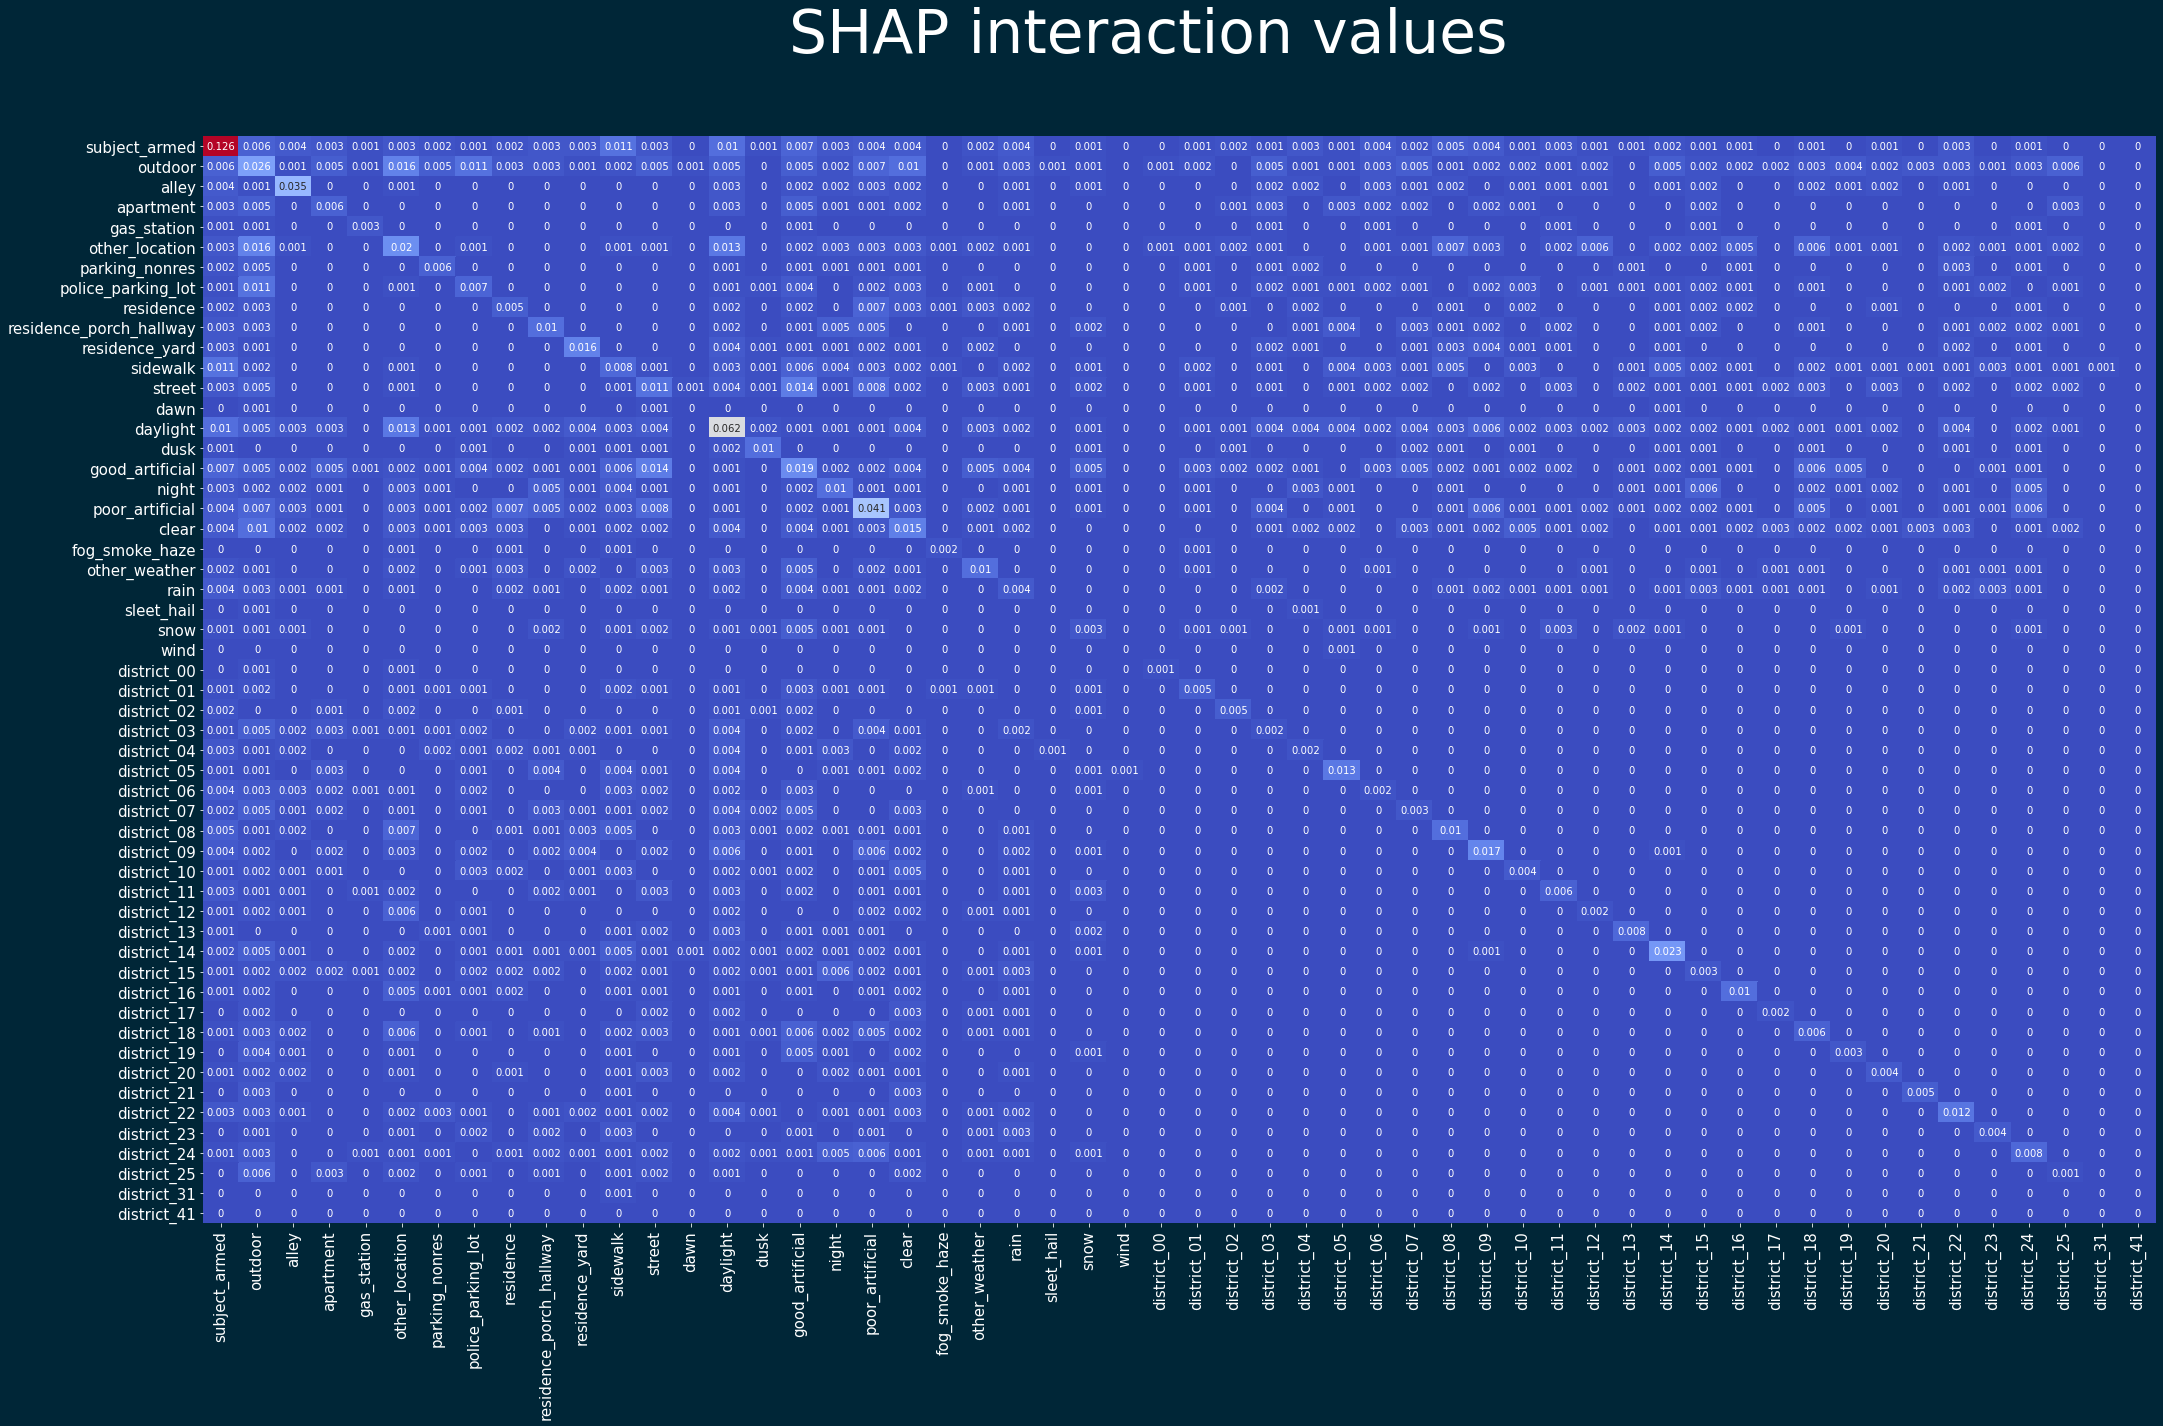

In [428]:
# Get absolute mean of matrices
mean_shap = numpy.abs(shap_interaction_values).mean(0)
ms = pandas.DataFrame(mean_shap, index=feats.columns, columns=feats.columns)

# times off diagonal by 2
ms.where(ms.values == numpy.diagonal(ms),ms.values*2, inplace=True)

# display 
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
seaborn.heatmap(ms.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()

In [418]:
# make sure the SHAP values add up to marginal predictions
shap_values = explanation.values
numpy.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

3.0204243659973145

## Event-level Prediction

### Add features by changing level of analysis to events instead of TRRs, which are somewhat invalid

In [ ]:
tr = pandas.read_csv('C:/Users/mason/OneDrive/Documents/CPD FOIA/output/main_actions_responses.csv')

In [379]:
# new event-level Features
ef = aa.groupby('event_id')
actions = ef.size()

In [27]:
# TRRs per event - feature and sample subset to simplify
trrs_per_event = df.groupby('event_id').size()
aa['trrs_event_size'] = aa['event_id'].map(trrs_per_event)

In [254]:
# officer actions
oa = aa[aa['person']=='officer']

In [255]:
# Map back from multiple 'action_coarse' values into one
quantify_force_level = {'none':0,'missing':0,'vague':0,'unclear':0,'911':0,'assisting':0,'backup':0,'possible error':0,\
                        'verbal':0,'presence':0,'self_protect':0,'pursuit':0,'hold':1,'arrest':1,'taser_display':1,\
                        'display_firearm':1,'compliance':1,'takedown':2,'stun':2,'taser_stun':2,'taser_probe':2,'canine':2,\
                        'pepper_spray':2,'take down/emergency handcuffing':2,'direct_mechanical':3,'baton':3,'lethal':4,\
                        'firearm':4,'other_deadly':4,'firearm_dog':4}

def adjudicate_actions_coarse(officer_force, method='higher'):
    if type(officer_force) == str:
        if ',' in officer_force:
            forces = officer_force.split(', ')
            levels = [quantify_force_level[x] for x in forces]
            level_to_force = dict(zip(levels,forces))
            max_level = max(levels)
            max_force = level_to_force[max_level]
            return(max_force)
        else:
            return(officer_force)
oa['action_coarse'] = oa['action_coarse'].apply(adjudicate_actions_coarse)

In [256]:
# subject actions
# features: resistance level, force_level, action_coarse vc
sa = aa[aa['person']=='subject']

In [257]:
resolve_subj_actions = {}
resolve_subj_actions['attack without weapon, pulled away'] = 'pulled away'
resolve_subj_actions['attack without weapon, imminent threat of battery'] = 'attack without weapon'
resolve_subj_actions['attack without weapon, pulled away, imminent threat of battery'] = 'attack without weapon'
resolve_subj_actions['attack without weapon, stiffened (dead weight)'] = 'attack without weapon'
resolve_subj_actions['uses force likely to cause death or great bodily harm, stiffened (dead weight)'] = 'imminent threat of battery'
resolve_subj_actions['pulled away, imminent threat of battery'] = 'imminent threat of battery'
resolve_subj_actions['pulled away, imminent threat of battery'] = 'pulled away'
resolve_subj_actions['stiffened (dead weight), pulled away'] = 'pulled away'
resolve_subj_actions['fled, pulled away'] = 'pulled away'
resolve_subj_actions['uses force likely to cause death or great bodily harm, pulled away'] = 'uses force likely to cause death or great bodily harm'
resolve_subj_actions['attack without weapon, uses force likely to cause death or great bodily harm'] = 'attack without weapon'
resolve_subj_actions['uses force likely to cause death or great bodily harm, imminent threat of battery'] = 'imminent threat of battery'
resolve_subj_actions['uses force likely to cause death or great bodily harm, stiffened (dead weight), pulled away'] = 'imminent threat of battery'
resolve_subj_actions['stiffened (dead weight), imminent threat of battery'] = 'stiffened (dead weight)'
resolve_subj_actions['pulled away, stiffened (dead weight)'] = 'pulled away'
resolve_subj_actions['uses force likely to cause death or great bodily harm, attack without weapon'] = 'attack without weapon'
resolve_subj_actions['pulled away, fled'] = 'fled'
resolve_subj_actions['uses force likely to cause death or great bodily harm, pulled away, imminent threat of battery'] = 'imminent threat of battery'
resolve_subj_actions['imminent threat of battery, stiffened (dead weight)'] = 'stiffened (dead weight)'
sa['action_coarse'] = sa['action_coarse'].replace(resolve_subj_actions)
#sa[sa['action_coarse']=='imminent threat of battery, stiffened (dead weight)'].head(50)

In [258]:
def add_column_prefix(df, prefix='officer_'):
    cols = df.columns.tolist()
    newcols = [prefix + x for x in cols]
    changecols = dict(zip(cols, newcols))
    df = df.rename(columns=changecols)
    return df

In [261]:
def action_features(df, party):
    party_prefix_map = {'subject':'subj_','officer':'officer_'}
    events = df.event_id.unique().tolist()
    events_ordered = []
    actions_ordered = []
    all_actions = df[df['person']==party].action_coarse.unique().tolist()
    for event in events:
        edf = df[df['event_id']==event]
        events_ordered.append(event)
        actions_ordered.append(edf.action_coarse.value_counts())
    out = pandas.DataFrame(index=events_ordered, data=actions_ordered, columns=all_actions)
    out = add_column_prefix(out, prefix=party_prefix_map[party])
    out = out.fillna(0)
    out = out.reset_index().rename(columns={'index':'event_id'})
    return out

In [66]:
aa = pandas.concat([oa,sa])
ds = aa[aa['trrs_event_size']==1]
#ds.isna().sum()

In [262]:
oaff = action_features(oa, party='officer')
saff = action_features(sa, party='subject')

In [272]:
single_trr_events = ds.event_id.unique().tolist()
o = oaff[oaff['event_id'].isin(single_trr_events)]
s = saff[saff['event_id'].isin(single_trr_events)]

In [288]:
len(o), len(s)

(18290, 18377)

In [130]:
# should we double count subject actions within same TRR?
# not for now...
highest_value = saff.max().max()
for val in range(2, highest_value+1):
    saff = saff.replace({val:1})

In [301]:
# Merge officer and subject action features into setting features
ef = dff.merge(o, on='event_id', how='right')
ef = ef.merge(s, on='event_id', how='left')
del ef['trr_id']
ef = ef.dropna()

In [303]:
esj = xgboost.XGBClassifier(n_estimators=50, max_depth=0, early_stopping_rounds=5, grow_policy='lossguide')
# to vary: grow_policy (depthwise, lossguide)
tgt = ef['subject_injured']
esj_feat_cols = [x for x in ef.columns.tolist() if x not in ['poinjured','subject_injured','subject_alleged_injury','event_id']]
esj_feats = ef[esj_feat_cols]
esj_x_train, esj_x_test, esj_y_train, esj_y_test = train_test_split(esj_feats, tgt, test_size=0.2, random_state=7)
esj.fit(X=esj_x_train, y=esj_y_train, eval_set=[(esj_x_test, esj_y_test)])

[0]	validation_0-logloss:0.51780
[1]	validation_0-logloss:0.51347
[2]	validation_0-logloss:0.51314
[3]	validation_0-logloss:0.51577
[4]	validation_0-logloss:0.52077
[5]	validation_0-logloss:0.52275
[6]	validation_0-logloss:0.52594


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [304]:
# Once subject and officer actions are added to the feautre set, 'subj_fled' achieves 40% of gain
pandas.DataFrame(data=esj.feature_importances_, index=esj_feat_cols).sort_values(by=0,ascending=False)

,0
subj_fled,0.395269
officer_firearm,0.090947
officer_direct_mechanical,0.055410
officer_taser_probe,0.027011
officer_none,0.023445
officer_baton,0.022465
officer_display_firearm,0.018191
subj_weapon(describe in additional info),0.014220
officer_takedown,0.013461
officer_pepper_spray,0.012570


In [307]:
out = "C:/Users/mason/OneDrive/Documents/CPD FOIA/model fits/event level w actions/"
esjb = esj.get_booster()
esjb.dump_model(out+'subject_injury_event_level_w_actions_trees.txt')#, out+'features.txt')
pred = esj.predict(esj_feats)
esj_explainer = shap.TreeExplainer(esjb)
esj_explanation = esj_explainer(esj_feats)

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 3.692362, while the model output was 0.135386. If this difference is acceptable you can set check_additivity=False to disable this check.

In [318]:
# Check max feature values
for col in esj_feats.columns:
    print(col, esj_feats[col].max())

subject_armed 1.0
outdoor 1
dawn 1
daylight 1
dusk 1
good_artificial 1
poor_artificial 1
night 1
clear 1
fog_smoke_haze 1
other_weather 1
rain 1
sleet_hail 1
snow 1
wind 1
alley 1
apartment 1
gas_station 1
other_location 1
parking_nonres 1
police_parking_lot 1
residence 1
residence_porch_hallway 1
residence_yard 1
sidewalk 1
street 1
officer_presence 3.0
officer_verbal 3.0
officer_hold 5.0
officer_takedown 3.0
officer_pepper_spray 3.0
officer_stun 2.0
officer_direct_mechanical 4.0
officer_pursuit 3.0
officer_compliance 4.0
officer_missing 3.0
officer_baton 3.0
officer_assisting 2.0
officer_arrest 2.0
officer_none 3.0
officer_self_protect 3.0
officer_display_firearm 2.0
officer_firearm 2.0
officer_possible error 1.0
officer_911 3.0
officer_taser_probe 5.0
officer_taser_stun 3.0
officer_canine 1.0
officer_backup 1.0
officer_other_deadly 1.0
officer_unclear 0.0
subj_did not follow verbal direction 3.0
subj_stiffened (dead weight) 3.0
subj_pulled away 4.0
subj_fled 2.0
subj_attack without 

In [309]:
esj_explanation = esj_explainer(esj_feats, check_additivity=False)

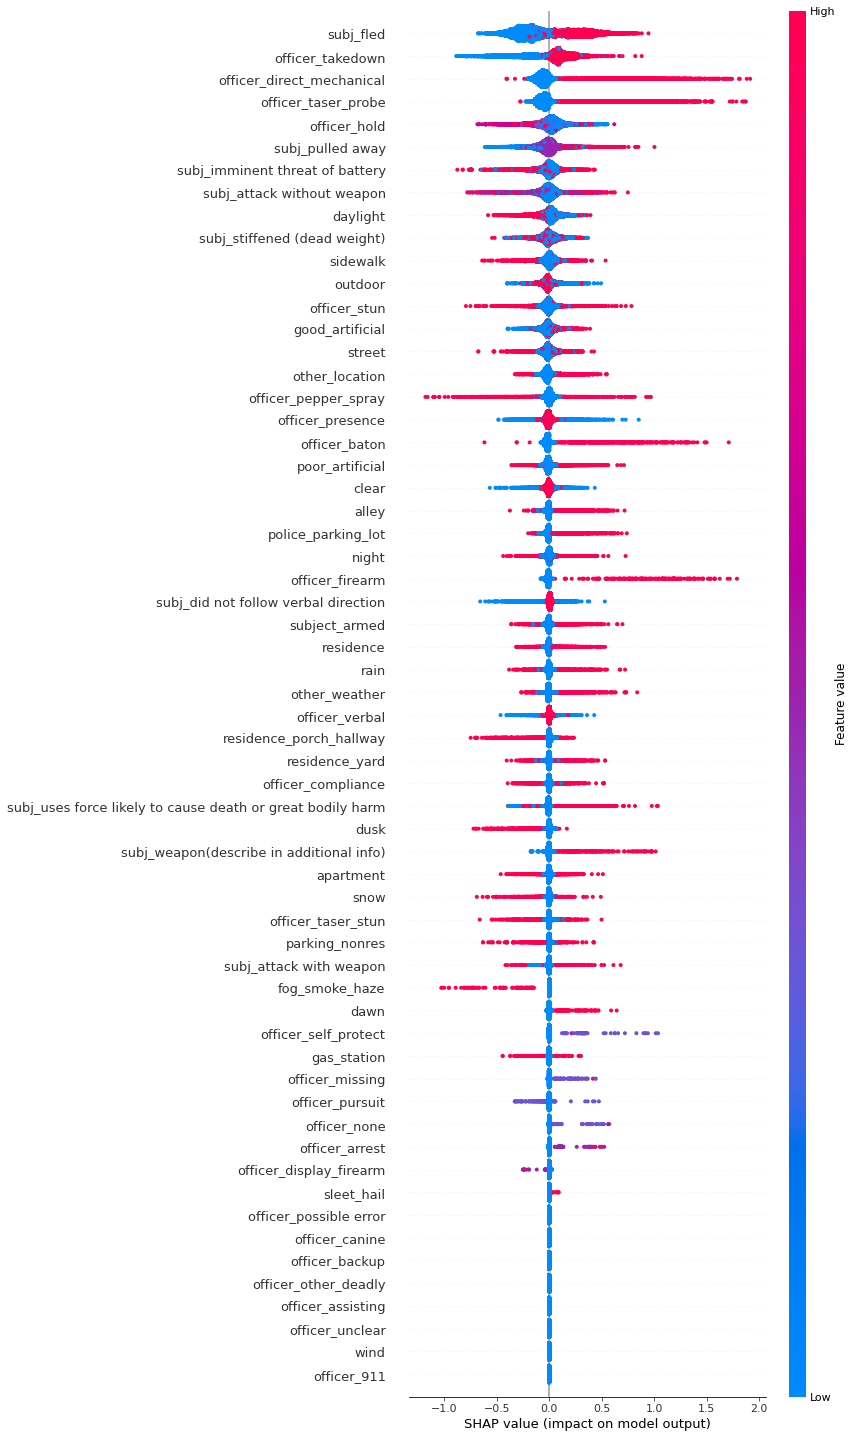

In [310]:
shap.plots.beeswarm(esj_explanation, max_display=len(esj_feats))

### Same but with all action counts reset to 1
#### No detectable change - keep officer action counts as they are

In [336]:
esj1 = xgboost.XGBClassifier(n_estimators=50, max_depth=0, early_stopping_rounds=5, grow_policy='lossguide')
esj_feats1 = esj_feats.copy()
highest_value = esj_feats1.max().max()
for val in range(2, int(highest_value)+1):
    esj_feats1 = esj_feats1.replace({val:1})
    
esj1_x_train, esj1_x_test, esj1_y_train, esj1_y_test = train_test_split(esj_feats1, tgt, test_size=0.2, random_state=7)
esj1.fit(X=esj1_x_train, y=esj1_y_train, eval_set=[(esj1_x_test, esj1_y_test)])

[0]	validation_0-logloss:0.51818
[1]	validation_0-logloss:0.51254
[2]	validation_0-logloss:0.51191
[3]	validation_0-logloss:0.51358
[4]	validation_0-logloss:0.51609
[5]	validation_0-logloss:0.51908
[6]	validation_0-logloss:0.52100
[7]	validation_0-logloss:0.52557


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [337]:
pandas.DataFrame(data=esj1.feature_importances_, index=esj_feat_cols).sort_values(by=0,ascending=False)

,0
subj_fled,0.368825
officer_direct_mechanical,0.138519
officer_firearm,0.092220
officer_baton,0.024255
officer_taser_probe,0.022744
officer_none,0.020125
subj_weapon(describe in additional info),0.014322
officer_display_firearm,0.013900
officer_takedown,0.012370
officer_missing,0.012179


In [339]:
out = "C:/Users/mason/OneDrive/Documents/CPD FOIA/model fits/event level w actions/"
esjb1 = esj1.get_booster()
esjb1.dump_model(out+'subject_injury_event_level_w_actions1_trees.txt')#, out+'features.txt')
pred1 = esj1.predict(esj_feats1)
esj1_explainer = shap.TreeExplainer(esjb1)
esj1_explanation = esj1_explainer(esj_feats1, check_additivity=False)

In [361]:
pp1 = esj1.predict_proba(esj_feats1)

In [463]:
# logloss of guessing sample mean for every prediction
base_rate = [(tgt.value_counts() / len(tgt))[1]]
base_rates = numpy.asarray(base_rate * len(tgt))
llt = log_loss(tgt, base_rates)
print(llt, 'naive logloss of guessing sample mean for every prediction')

# Achieved logloss
lla = log_loss(tgt, pp1)
print(lla, 'achieved logloss')
print('a reduction of', round((llt-lla)/llt, 4)*100, '%')

0.5309699797185163 naive logloss of guessing sample mean for every prediction
0.45317027833951773 achieved logloss
a reduction of 14.649999999999999 %


In [371]:
pf = pandas.DataFrame(pp1)
pf['gt'] = tgt

In [421]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

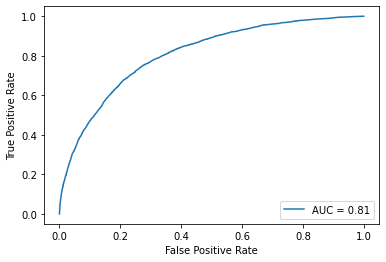

In [422]:
# ROC-AUC Score/Curve
rc = roc_curve(tgt, pf[1])#[:1]
dsp = metrics.RocCurveDisplay(fpr=rc[0],tpr=rc[1], roc_auc=auc(rc[0],rc[1]))
dsp.plot()
plt.show()
# ROC AUC
roc_auc_score(tgt, pf[1])

In [352]:
0.732494*(1-0.732494)

0.19594653996400002

In [359]:
esj1.best_score

0.5119119023919008

In [346]:
df.subject_injured.value_counts() / len(df)

0.0    0.732494
1.0    0.266402
Name: subject_injured, dtype: float64

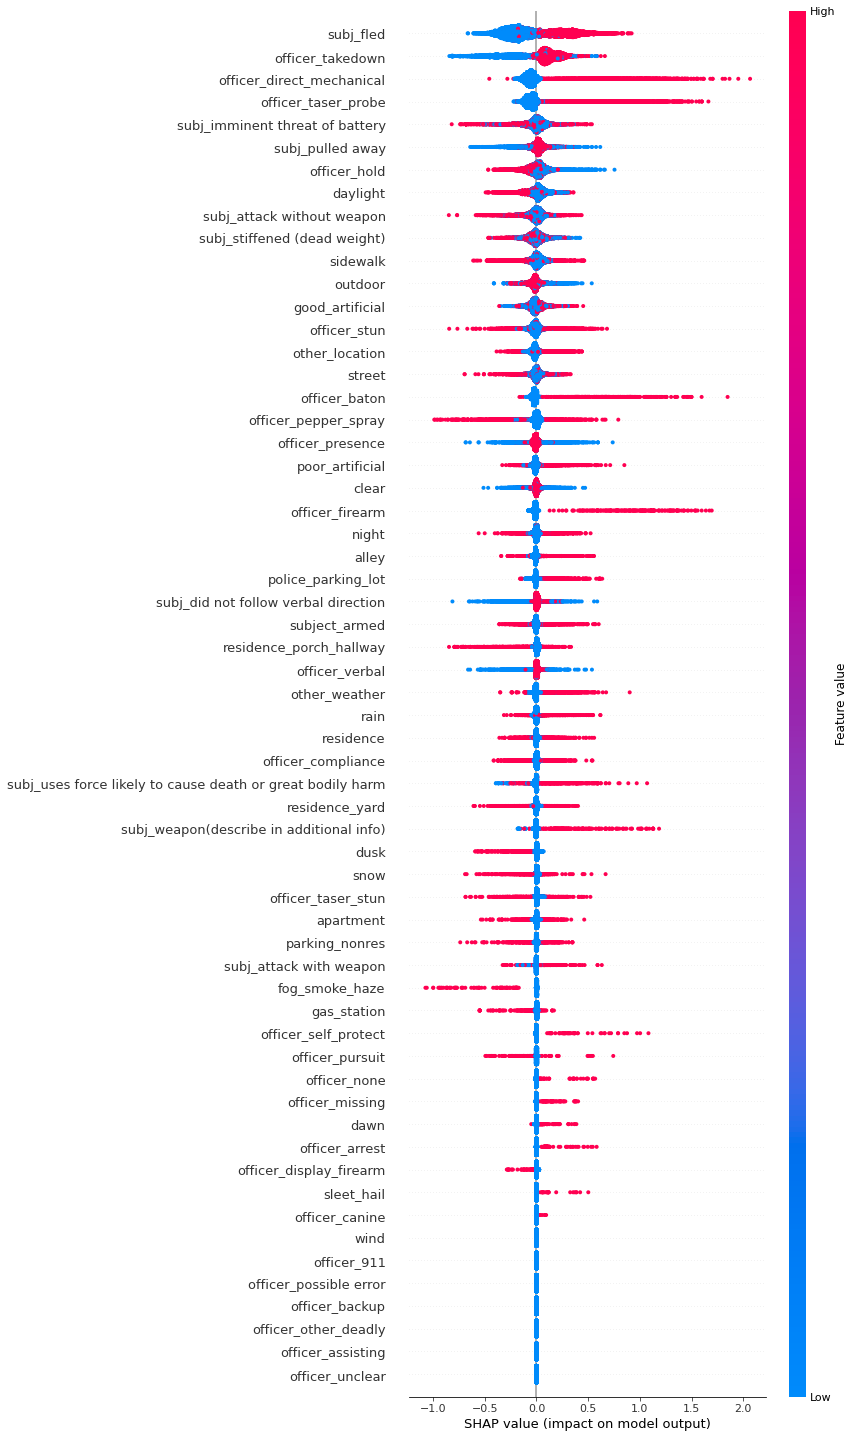

In [340]:
shap.plots.beeswarm(esj1_explanation, max_display=len(esj_feats1))

In [ ]:
# Add ordinal force levels in addition to action dummies?
#pandas.crosstab(sa['force_level'],sa['action_coarse'])
#pandas.crosstab(oa['force_level'],oa['action_coarse'])

In [ ]:
#trrs.value_counts() / len(ef) # 57% of events are a single TRR 

In [ ]:
### Next, fit model on multiple-officer, single-subject events
### Then, multiple-officer, multiple-subject events
### What about changing the level of the analysis to subject-force incidents instead of events?

### Old - keep for later repurposing

In [7]:
# Add to recoding blocks
subj_race_recode = {'BLACK':'black','HISPANIC':'hispanic','WHITE':'white','ASIAN/PACIFIC ISLANDER':'asian',\
                    'NATIVE AMERICAN/ALASKAN NATIVE':'aian'}
trr['subj_race'] = trr.subj_race.replace(subj_race_recode)
trr['subj_male'] = trr.subj_gender.replace({'MALE':1,'FEMALE':0})
#trr['subj_male'] = trr['subj_male'].astype(int)
trr.direction = trr.direction.fillna('')
trr['notify_trr'] = trr.notify_OEMC + trr.notify_district_sergeant
trr['notify_trr'] = trr['notify_trr'].replace({2:1})

trr['member_fired_first'] = (trr['party_fired_first'] == 'MEMBER').replace({True:1,False:0})
trr['offender_fired_first'] = (trr['party_fired_first'] == 'OFFENDER').replace({True:1,False:0})
trr['other_fired_first'] = (trr['party_fired_first'] == 'OTHER').replace({True:1,False:0})

trr['uid'] = trr['UID'].fillna(0)
trr['uid'] = trr['uid'].astype(int)

In [126]:
trr.officer_force.value_counts().to_dict()
# is it okay to take the more severe force for actions with 2+ regex hits?
# good: "taser_display, taser_probe" n=4,417
# good: "taser_display, stun" n=1,195, "taser_stun, taser_display" (n=30)
# good: "hold, verbal" (n=44); "hold, compliance" (n=35); "baton, hold"
# bad: "hold, self_protect" n=79 something's wrong, these aren't hitting holds
trr[trr['officer_force']=='hold, stun'].action.value_counts().to_dict()

{'verbal': 63155,
 'presence': 59966,
 'hold': 56555,
 'hold, takedown': 46364,
 'stun': 11763,
 'direct_mechanical': 10979,
 'compliance': 4987,
 'taser_probe': 4431,
 'pepper_spray': 4128,
 'baton': 2034,
 'taser_stun': 1237,
 'firearm': 1092,
 'taser_display': 816,
 'self_protect': 381,
 'pursuit': 375,
 'takedown': 357,
 'arrest': 312,
 'missing': 233,
 'display_firearm': 225,
 'none': 209,
 'canine': 123,
 'hold, self_protect': 84,
 'hold, arrest': 74,
 'hold, stun': 53,
 'assisting': 51,
 '911': 51,
 'hold, verbal': 44,
 'hold, compliance': 35,
 'backup': 28,
 'possible error': 22,
 'hold, baton': 21,
 'takedown, stun': 15,
 'verbal, display_firearm': 11,
 'hold, pursuit': 11,
 'backup, assisting': 11,
 'other_deadly': 10,
 'hold, self_protect, direct_mechanical': 9,
 'pepper_spray, none': 9,
 'arrest, pursuit': 9,
 'taser_probe, taser_stun': 8,
 'pepper_spray, takedown': 8,
 'self_protect, direct_mechanical': 7,
 'stun, direct_mechanical': 7,
 'compliance, baton': 7,
 'hold, pep

In [15]:
trr = trr.rename(columns={'taser':'taser_used'})
newcols = ['event_id','trr_id','beat','assigned_beat','address','location_type','location','indoor','lighting_condition',\
           'weather_condition','datetime','notify_trr','taser_used','firearm_used','member_fired_first','offender_fired_first',\
           'other_fired_first','number_of_weapons_discharged','total_number_of_shots','number_of_officers_using_firearm',\
           'subj_male','subj_race','subj_age','subj_armed','subj_injured','subj_alleged_injury','subject_ID','subject_no',\
           'weapons','subj_weapons','uid','off_injured','unit.detail','beat_was_assigned','force_type','resistance_type',\
           'resist_level','person','action','action_levels','subj_action_level','officer_force','officer_action_level']
trr = trr[newcols]
# Re-sort 
trr = trr.sort_values(by=['event_id','trr_id','resist_level','action_levels','person'],ascending=[True,True,True,True,False])
#trr.to_csv('C:/Benchmark Analytics/my output/TRRs merged.csv')

In [ ]:
def convert_timedelta(timedelta, to='hours'):
    days = timedelta.days
    seconds = timedelta.seconds
    if to=='hours':
        hours = (days*24) + (seconds / 60 / 60)
        return(hours)
    if to=='days':
        d = days + (seconds / 60 / 60 / 24)
        return(d)

### Subject Weapons - clean, recode

In [ ]:
# Subject Weapons
swp = {}
swp['none'] = ['none','active resister','resisting','fighting stance','resisted','see narrative','see below','see above',\
              'struggle','flee','obstructed','stated','resist','defeat','see unusual circumstances','unknown']
swp['threat'] = ['physical advancement','furtive movements','approached','threaten','pointed weapon']
swp['verbal'] = ['verbal threat (assault)','verbal','threats']
swp['arms'] = ['hands/fists','pushed','elbow','punch','arm','lunge','pull','shove','shoulder','fists','hands','grabbed',\
               'thrown','scratched','assault','fist','grab','strike','struck','poked','scratching']
swp['legs'] = ['feet','kick','knee','kincked','legs']
swp['mouth'] = ['mouth','spit','bite','teeth','blood','saliva','spat','bit']
swp['head'] = ['headbutt','head butt','head-butt','head']
swp['body'] = ['body check','chest bump','body','charged at officer','bumped','rushed','tackle','charged officer','chest',\
              'tackle','charge','buttocks','wrestled','run into','jumped on back']
swp['dog'] = ['dog','pit bull','pitbull']
swp['knife'] = ['knife','other cutting instrument','razor blade','glass','knives']
swp['object'] = ['blunt instrument','bat','club','pen','cane','bottle','roman candle','bicycle','concrete','screwdriver',\
                'chair','hammer','brick','brass knuckles','rock','handcuff','asp','scissors','fork','rake','chain','belt',\
                 'keys','wire rack','pipe','steel','tv','rail','mug','skateboard','tools','crate','cigarette','metal',\
                'rack','crutches','leg-lock','bike','fireworks','police radio','screw driver','stick',\
                'firework','wood','drawer','struck with object','cigar','cellphone','frying pan','iron','can','hand cuffs',\
                'nails','dumbbell','blunt','cell phone','umbrella','dockers']
swp['stun'] = ['pepper spray','stun','taser','pole','cemical','chemical','tazer','mace']
swp['projectile'] = ['bb gun','thrown object','shoe','paint ball','air pistol','pellet gun','othertoy','bb/pellet','threw',\
                    'caustic substance','food']
swp['door'] = ['door','gate']
swp['vehicle'] = ['vehicle','strike officer with vehicle','officer struck with vehicle','automobile','automobille']
swp['firearm'] = ['firearm','shotgun','handgun','shoot','9 mmmac 11','otherreplica','replica','9 mmintratech tec-dc9',\
                  'point gun','draw gun','fully automatic']
swp['implied'] = ['implied','reached','pointed weapon','indicated','weapon viewed']

def convert_subject_weapon(value):
    """Recode subject weapons into categories coarse enough for feature engineering"""
    # split by comma
    if type(value) == str:
        if value == 'n':
            return(numpy.nan)
        else:
            vals = value.split(', ')
            hits = []
            for val in vals:
                for weapon in swp:
                    for keyword in swp[weapon]:
                        if keyword in value:
                            hits.append(weapon)
            if hits != []:
                h = list(set(hits))
                out = ', '.join(h)
                return(out)
trr['subj_weapons'] = trr['weapons'].apply(convert_subject_weapon)

In [ ]:
def clean_subj_weapons(df):
    # Subject weapons causing duplicate lines, so merge all into 1 cell
    df = df.fillna('')
    for c in df.columns.tolist()[1:]:
        df[c] = df[c].str.lower()
        df[c] = df[c].str.replace('other (specify)', '', regex=False)
    df['weapon'] = df['weapon_type'] + ' ' + df['firearm_caliber'] + df['weapon_description']
    new = pandas.DataFrame(columns=['trr_id', 'weapons'])
    counter = 0
    for trr_id in df.trr_id.unique():
        rel = df[df['trr_id']==trr_id]
        if len(rel) == 1:
            new.loc[counter] = {'trr_id':trr_id, 'weapons':rel.weapon.values[0]}
            counter += 1
        else:
            weapons = rel.weapon.tolist()
            weapons = [x.strip() for x in weapons]
            weapons = ', '.join(weapons)
            new.loc[counter] = {'trr_id':trr_id, 'weapons':weapons}
            counter += 1
    new['weapons'] = new['weapons'].str.strip()
    new['weapons'] = new['weapons'].replace({'.':numpy.nan,'/':numpy.nan})
    return(new)

In [ ]:
# investigate results - still more recoding needed
sw = trr[~pandas.isnull(trr['weapons'])]
sw = sw[pandas.isnull(sw['subj_weapons'])]
sw.weapons.value_counts().to_dict()
#trr['subj_weapons'].value_counts()

### Charges & Weapon Discharges

In [16]:
# Charges & Weapons-Discharges merge greatly reduces TRR file legibility, so better off separate
# Charges
chg = chg.rename(columns={'subject_no':'chg_subject_no','description':'charge_description'})

# Weapons-Discharges
wd = pandas.read_csv(path+'/TRR/TRR-weapon-discharges_2004-2016_2016-09.csv')
wd['weapon_type'] = wd['weapon_type'].replace({'OTHER (SPECIFY)':numpy.nan})
wd.weapon_type.fillna(wd['weapon_type_description'], inplace=True)
wdcols = wd.columns.tolist()[1:]
wdcols.remove('total_number_of_shots')
wdcols.remove('number_of_catdridge_reloaded')
for c in wdcols:
    wd[c] = wd[c].str.lower()
wd['NaN'] = numpy.nan
for i in wd.index:
    if wd.loc[i, 'weapon_type'] == wd.loc[i, 'weapon_type_description']:
        wd.loc[i, 'weapon_type_description'] = numpy.nan
    wd.loc[i, 'NaN'] = wd.loc[[i]].isna().sum().sum()
    
# Recode Weapon Types
wd_recode = {'taser contact stun':'taser (drive stun mode)','taser - contact stun':'taser (drive stun mode)',\
            'taser dry stun':'taser (drive stun mode)','taser (contact stun)':'taser (drive stun mode)','asp':'baton',\
            'asp-baton':'baton','asp baton':'baton','asp batton':'baton','taser - stun only':'taser (drive stun mode)',\
            'taser stun':'taser (drive stun mode)','taser no probe':'taser (drive stun mode)','taser body contact':\
            'taser (drive stun mode)','extendable baton':'baton','taser - no probes':'taser (drive stun mode)',\
            'taser spark display':'taser display','taser contact strike':'taser (drive stun mode)','contact stun taser':\
            'taser (drive stun mode)','revolver':'semi-auto pistol','expandable baton':'baton',' contact stun':\
            'taser (drive stun mode)','taser / no probe discharged':'taser display','open hand strike':'hands',\
            'taser (spark display only)':'taser display','taser contact':'taser (drive stun mode)','taser drive stun':\
            'taser (drive stun mode)','auto':'car','brick':'blunt force instrument','semi-auto pistol':'gun',\
            'rifle':'gun','shotgun':'gun'}
wd.weapon_type = wd.weapon_type.replace(wd_recode)
# So fucking annoying
weapon_type_from_make_fill = {'taser--us--(fires electrically charged darts.)':'taser','remington arms co. inc.':'gun'}
wd['weapon_type'] = wd['weapon_type'].fillna(wd['firearm_make'].replace(weapon_type_from_make_fill))

### Load other TRR/UoF relevant data points

In [280]:
# Charges
ca = pandas.read_excel(path+'P10655-FOIA-P046360-TRRdata.xlsx', sheet_name='Charges', converters={'names':str,'ages':str})
ca.columns = ca.columns.str.lower()
# Weapon Discharges
wd = pandas.read_excel(path+'P10655-FOIA-P046360-TRRdata.xlsx', sheet_name='WeaponDischarges')
wd.columns = wd.columns.str.lower()
# Subject Weapons
sw = pandas.read_excel(path+'P10655-FOIA-P046360-TRRdata.xlsx', sheet_name='SubjectWeapons')
sw.columns = sw.columns.str.lower()
# Statuses
st = pandas.read_excel(path+'P10655-FOIA-P046360-TRRdata.xlsx', sheet_name='Statuses_OtherMembers')
st.columns = st.columns.str.lower()
# Stars
star = pandas.read_excel(path+'P10655-FOIA-P046360-TRRdata.xlsx', sheet_name='Star #')
star.columns = star.columns.str.lower()

### Supervisor Approval of TRRs

In [ ]:
# time between TRR submittance and event timestamp
# time between submittance and review
# time between review and approval

In [17]:
# TRR Supervisor Approval features: time to submit, time to review, and time to approve
stat['datetime'] = pandas.to_datetime(stat['status_date'] + ' ' + stat['status_time'])
times = trr[['event_id','trr_id','datetime']]
times = times.drop_duplicates(subset='trr_id')
times = times.reset_index(drop=True)
for i in times.index:
    trr_id = times.loc[i, 'trr_id']
    datetime = times[times['trr_id']==trr_id].datetime.tolist()[0]
    s = stat[stat['trr_id']==trr_id]
    statuses = ['SUBMITTED','REVIEWED','APPROVED']
    for status in statuses:
        try:
            status_time = s[s['status']==status].datetime.tolist()[0]
            times.loc[i, status] = convert_timedelta(status_time - datetime)
        except:
            times.loc[i, status] = 'not found'
times = times.rename(columns={'SUBMITTED':'submitted','REVIEWED':'reviewed','APPROVED':'approved'})
times = times.replace('not found',numpy.nan)
# fill missing timestamps with sample mean of submitted, reviewed, or approved
times['submitted'] = times['submitted'].fillna(times['submitted'].mean()) # only 22 missing
times['reviewed'] = times['reviewed'].fillna(times['reviewed'].mean()) # only 2 missing
times['approved'] = times['approved'].fillna(times['approved'].mean()) # 0 missing
times['submit_to_review'] = times['reviewed'] -  times['submitted']
times['review_to_approval'] = times['approved'] -  times['reviewed']
times = times.rename(columns={'submitted':'time_to_submit'})

### Complaints & Settlements match

In [16]:
c = pandas.read_csv('C:/Benchmark Analytics/my output/force related complaints.csv') # match on: uid, date,address, location
c.address = c.address.str.replace('*','x')

In [17]:
s = pandas.read_csv('C:/Benchmark Analytics/my output/excessive force settlements.csv') 
# match on: uid, date, location(if filled)
s = s.rename(columns={'location':'address','UID':'uid'})
s.address = s.address.replace('Not specified','')
s.address = s.address.str.lower()
s = s[['case_id','settlement','complaint','incident_date','address','uid']]
s.uid = s.uid.fillna(0)
s.uid = s.uid.astype(int).astype(str)
s.uid = s.uid.replace('',numpy.nan)

In [18]:
# new TRR file for matching with complaints/settlements
unique_trr = trr.drop_duplicates(subset='trr_id') 
tm = unique_trr[['event_id','trr_id','beat','location_type','location','indoor',\
                 'datetime','address','uid']]
tm = tm.reset_index(drop=True)
tm['date'] = tm['datetime'].dt.date
tm.uid = tm.uid.astype(str)

In [19]:
# Matching
for i in s.index:
    date = pandas.to_datetime(s.loc[i, 'incident_date']).date()
    addy = s.loc[i, 'address']
    uid = s.loc[i, 'uid']
    t = tm[tm['date']==date]
    if uid in t.uid.tolist():
        if uid != 0:
            s.loc[i, 'date_uid_match'] = 1
            t = t[t['uid']==uid]
            trr_addy = t.address.tolist()[0]
            trr_id = t.trr_id.tolist()[0]
            s.loc[i, 'trr_id'] = int(trr_id)
            s.loc[i, 'trr_address'] = trr_addy
            s.loc[i, 'address_match_ratio'] = fuzz.ratio(trr_addy, addy)
s = s[['case_id','settlement','complaint','uid','incident_date','address','trr_address','trr_id','date_uid_match',\
       'address_match_ratio']]

In [20]:
s[s['date_uid_match']==1].sort_values(by='address_match_ratio', ascending=False).head(20)

,case_id,settlement,complaint,uid,incident_date,address,trr_address,trr_id,date_uid_match,address_match_ratio
756,11-CV-8731,"$20,000",Excessive force/minor,131985,12/11/2010,3700 s. wentworth ave.,37xx s wentworth ave,56922.0,1.0,86.0
796,10-CV-4609,"$99,999",Excessive force,127187,5/18/2010,5700 s. winchester ave.,57xx s winchester ave,51106.0,1.0,86.0
932,09-L-13503,"$1,500,000",Excessive force/serious,122456,3/10/2009,6300 s. hermitage ave.,63xx s hermitage ave,39088.0,1.0,86.0
967,09-CV-6970,"$7,500",Excessive force/minor,115919,11/7/2008,6100 n. ravenswood ave.,61xx n ravenswood ave,36215.0,1.0,86.0
367,14-CV-1320,"$5,000",Excessive force/minor,123182,2/12/2013,9500 s. wentworth ave.,95xx s wentworth ave,75602.0,1.0,86.0
834,11-CV-2529,"$7,500",Excessive force,118512,4/15/2010,10900 s. vincennes ave.,109xx s vincennes ave,50242.0,1.0,86.0
453,10-CV-5310,"$117,116",Excessive force/minor,131814,6/13/2009,1500 s. christiana ave.,15xx s christiana ave,41710.0,1.0,86.0
795,12-CV-3535,"$62,500",Excessive force,127187,5/18/2010,5700 s. winchester ave.,57xx s winchester ave,51106.0,1.0,86.0
420,11-CV-3776,"$15,000",Excessive force/minor,132117,11/11/2010,3900 w. lexington st.,39xx w lexington st,56276.0,1.0,85.0
250,09-CV-5581,"$5,426",Excessive force/minor,114814,9/6/2007,3100 w. roosevelt rd.,31xx w roosevelt rd,25028.0,1.0,85.0


In [23]:
chg[chg['trr_id']==67101]

,trr_id,sr_no,statute,charge_description,chg_subject_no
123234,67101,26581.0,520 ILCS 5.0/1.22,RESIST/OBSTRUCT OFFICER,26619.0
123235,67101,26581.0,625 ILCS 40.0/2-4,RESISTANCE TO OFFICER,26619.0
123236,67101,26581.0,720 ILCS 5.0/12-3-A-1,BATTERY - CAUSE BODILY HARM,26619.0
123237,67101,26581.0,720 ILCS 5.0/12-5-A,RECKLESS CONDUCT,26619.0


In [22]:
chg[chg['trr_id']==67104]

,trr_id,sr_no,statute,charge_description,chg_subject_no
123242,67104,26581.0,520 ILCS 5.0/1.22,RESIST/OBSTRUCT OFFICER,26622.0
123243,67104,26581.0,625 ILCS 40.0/2-4,RESISTANCE TO OFFICER,26622.0
123244,67104,26581.0,720 ILCS 5.0/12-3-A-1,BATTERY - CAUSE BODILY HARM,26622.0
123245,67104,26581.0,720 ILCS 5.0/12-5-A,RECKLESS CONDUCT,26622.0


In [24]:
chg[chg['trr_id']==67107]

,trr_id,sr_no,statute,charge_description,chg_subject_no
123248,67107,26584.0,515 ILCS 5.0/1-200,OBSTRUCTING AN OFFICER,26619.0
123249,67107,26584.0,520 ILCS 5.0/1.22,RESIST/OBSTRUCT OFFICER,26619.0
123250,67107,26584.0,720 ILCS 5.0/12-5-A,RECKLESS CONDUCT,26619.0


In [25]:
chg[chg['trr_id']==67108]

,trr_id,sr_no,statute,charge_description,chg_subject_no
123251,67108,26581.0,520 ILCS 5.0/1.22,RESIST/OBSTRUCT OFFICER,26623.0
123252,67108,26581.0,625 ILCS 40.0/2-4,RESISTANCE TO OFFICER,26623.0
123253,67108,26581.0,720 ILCS 5.0/12-3-A-1,BATTERY - CAUSE BODILY HARM,26623.0
123254,67108,26581.0,720 ILCS 5.0/12-5-A,RECKLESS CONDUCT,26623.0


### Generate event- and TRR-level features

In [21]:
def convert_to_binary(value):
    if value=='Yes':
        out = 1
        return(out)
    elif value=='No':
        out = 0
        return(out)
    elif value=='missing':
        return('missing')

In [22]:
def fill_missing(df, level='event'):
    df = df.replace(to_replace='missing',value=numpy.nan)
    event_cols = ['location','location_type','indoor','address','beat','lighting_condition','weather_condition']
    trr_cols = ['subj_male','subj_race','subj_age','subject_no','assigned_beat','uid']
    cols_map = {'event':event_cols,'trr':trr_cols}
    for c in cols_map[level]:
        df[c] = df[c].fillna(method='bfill')
        df[c] = df[c].fillna(method='ffill')
    return(df)

In [23]:
def collect_strings(df, column='subj_weapons', unique=True):
    vals_list = df[column].unique().tolist()
    vals_list = [x for x in vals_list if x is not None] # removes "None"
    vals_list = [x for x in vals_list if x==x] # removes NaNs
    vals_list = [str(x) for x in vals_list]
    l1 = ', '.join(vals_list)
    l2 = l1.split(', ')
    if unique:
        l3 = list(set(l2))
        return(l3)
    else:
        return(l2)

In [24]:
def extract_trr_features(trr_df, charges_df, weapons_discharges_df, event_id):
    df = trr_df[trr_df['event_id']==event_id]
    df = fill_missing(df, level='event')
    offs = df.uid.unique().tolist()
    subjs = df.subject_ID.unique().tolist()
    trrs = df.trr_id.unique().tolist()
    datetime = df.datetime.tolist()[0]
    # Event-level features
    ef = {}
    ef['event_id'] = event_id
    ef['trrs'] = trrs
    ef['trr_count'] = len(trrs)
    ef['subjects'] = subjs
    ef['subj_count'] = len(subjs)
    ef['officers'] = offs
    ef['officer_count'] = len(offs)
    ef['event_off_subj_ratio'] = len(offs) / len(subjs)
    ef['datetime'] = datetime
    ef['hour'] = datetime.hour + (datetime.minute/60) # hour:0-24
    ef['weekday'] = datetime.weekday() # Monday=0, Sunday=6
    ef['address'] = df.address.values[0]
    ef['location'] = df.location.tolist()[0] # dummies
    ef['location_count'] = len(df.location.unique())
    ef['location_type'] = df.location_type.tolist()[0] # dummies
    ef['indoor'] = df.indoor.tolist()[0]
    ef['lighting'] = df.lighting_condition.tolist()[0] # dummies
    ef['weather'] = df.weather_condition.tolist()[0] # dummies
    ef['beat'] = df.beat.tolist()[0] # where incident occurred
    for subj in subjs:
        sdf = df[df['subject_ID']==subj]
        resistance_levels = df.resist_level.tolist()
        s = {}
        s['subj_id'] = subj
        s['subj_race'] = sdf.subj_race.values[0]
        s['subj_male'] = sdf.subj_male.values[0]
        s['subj_age'] = sdf.subj_age.values[0]
        s['off_to_subj'] = len(sdf.uid.unique())
        s['subj_injury'] = convert_to_binary(sdf.subj_injured.values[0]) # prediction target - binary
        s['subj_alleg_injury'] = convert_to_binary(sdf.subj_alleged_injury.values[0]) # prediction target - binary
        s['subj_weapons'] = collect_strings(sdf, column='subj_weapons', unique=True) # category dummies
        s['resistance_actions'] = sdf.resist_level.value_counts() # category counts of actions at each resistance level (1-4)
        s['subj_actions'] = collect_strings(sdf, column='subj_action_level', unique=False) # category counts of actual actions
        s['force_actions'] = collect_strings(sdf, column='officer_force', unique=False) # category counts
        ef['subj_'+str(subjs.index(subj)+1)] = s
            
    ef['trrs'] = trrs
    # a TRR is a pairing of a set of actions between an officer and a subject. However, event actions are duplicated across TRRs
    for trr in trrs:
        tdf = df[df['trr_id']==trr]
        tdf = fill_missing(tdf, level='trr')
        # TRR-level features
        tf = {}
        # subject features
        tf['trr_id'] = trr
        tf['subj_alleg_injury'] = convert_to_binary(df.subj_alleged_injury.values[0])
        tf['subj_injury'] = convert_to_binary(df.subj_injured.values[0]) # prediction target
        tf['subj_id'] = tdf.subject_ID.values[0]
        tf['subj_no'] = tdf.subject_no.values[0]
        tf['subj_race'] = tdf.subj_race.values[0] # dummies
        tf['subj_male'] = tdf.subj_male.values[0]
        tf['subj_age'] = tdf.subj_age.values[0]
        tf['subj_weapons'] = tdf.weapons.values[0]
        
        # officer features
        tf['uid'] = tdf.uid.values[0]
        tf['unit.detail'] = tdf['unit.detail'].values[0]
        tf['home_beat'] = tdf['beat_was_assigned'].values[0]
        tf['off_injury'] = convert_to_binary(tdf.off_injured.values[0])
        tf['notify'] = tdf.notify_trr.values[0]
        tf['assigned_beat'] = tdf.assigned_beat.tolist()[0]
        
        # Actions - Subject
        tdf_sa = tdf[tdf['person']=='Subject']
        subj_actions = tdf_sa.action.tolist() # should be unique
        tf['subj_actions_count'] = len(subj_actions)
        tf['subj_actions'] = subj_actions
        tf['subj_action_levels'] = tdf_sa.subj_action_level.tolist()
        
        # Actions - Officer
        tdf_oa = tdf[tdf['person']=='Officer']
        off_actions = tdf_oa.action.tolist()
        tf['off_actions_count'] = len(off_actions)
        tf['off_actions'] = tdf_oa.action.tolist()
        tf['off_action_levels'] = tdf_oa.officer_action_level.tolist()
        
        # Charges
        chg = charges_df[charges_df['trr_id']==trr]
        if len(chg) > 0:
            tf['charges'] = dict(zip(chg.statute.tolist(), chg.charge_description.tolist()))
            tf['charge_subj_no'] = chg.chg_subject_no.tolist()[0]
        else:
            tf['charges'] = 'none'
            tf['charge_subj_no'] = 'none'
        
        # Other Context
        tf['weapons_discharged'] = tdf.number_of_weapons_discharged.values[0]
        tf['officers_using_firearm'] = tdf.number_of_officers_using_firearm.values[0]
        tf['total_shots'] = tdf.total_number_of_shots.values[0] # event 1153 invalidates this:3 offs shooting but 0 total shots
        tf['member_fired_first'] = tdf.member_fired_first.values[0]
        tf['offender_fired_first'] = tdf.offender_fired_first.values[0]
        tf['other_fired_first'] = tdf.other_fired_first.values[0]
        
        # Weapons-Discharges
        wd = weapons_discharges_df[weapons_discharges_df['trr_id']==trr]
        tf['weapon_discharges'] = len(wd)
        weapon_types = wd.weapon_type.tolist()
        for weapon in weapon_types:
            wdw = wd[wd['weapon_type']==weapon]
            if len(wdw) > 0:
                wt = {}
                wt['weapon_type'] = weapon
                wt['object_struck'] = wdw.object_struck_of_discharge.tolist()[0] # dummies
                wt['discharge_distance'] = wdw.discharge_distance.tolist()[0] # dummies
                wt['firearm_caliber'] = wdw.firearm_caliber.tolist()[0] # dummies
                tf['weapon_discharge_'+str(weapon_types.index(weapon)+1)] = wt
            
        ef['trr_'+str(trrs.index(trr)+1)] = tf # Add TRR to event dict
    return(ef)

In [25]:
# Processing all TRR events
events = []
for event in trr.event_id.unique():
    try:
        ef = extract_trr_features(trr, chg, wd, event_id=event)
    except:
        trrs = trr[trr['event_id']==event].trr_id.unique().tolist()
        print('Event ID:', event)
        print('TRR IDs:', trrs)
        ef = extract_trr_features(trr, chg, wd, event_id=event)
    events.append(ef)

In [42]:
# Max TRRs in a single event = 17 !!!!!
trr_counts = {}
for event in events:
    trr_counts[event['trr_count']] = event
trr_counts[max(trr_counts)]
t = trr[trr['event_id']=='4644.2']

In [ ]:
# Weapon Discharges Max
wd_counts = {}
for event in events:
    trrs = events[event]['trrs']
    for trr in trrs:
        events[event][trr][wd]
    trr_counts[event['trr_count']] = event
trr_counts[max(trr_counts)]
t = trr[trr['event_id']=='4644.2']
l = trr.event_id.unique().tolist()
l.index('4644.2')

In [26]:
events[24076]
# fill nans at event level

{'event_id': '4644.2',
 'trrs': [62149,
  62150,
  62151,
  62155,
  62158,
  62162,
  62163,
  62164,
  62165,
  62166,
  62167,
  62169,
  62170,
  62171,
  62173,
  62175,
  62177],
 'trr_count': 17,
 'subjects': [41257,
  41258,
  41259,
  41260,
  41261,
  41262,
  41263,
  41264,
  41265,
  41266,
  41267,
  41268],
 'subj_count': 12,
 'officers': [107792,
  109806,
  132269,
  132053,
  124655,
  101110,
  120737,
  124001,
  131115,
  126171,
  123507,
  109826],
 'officer_count': 12,
 'event_off_subj_ratio': 1.0,
 'datetime': Timestamp('2011-06-26 04:15:00'),
 'hour': 4.25,
 'weekday': 6,
 'address': '28xx w 25th st',
 'location': 'outside_residence',
 'location_count': 3,
 'location_type': 'residence',
 'indoor': 0,
 'lighting': 'good artificial',
 'weather': 'clear',
 'beat': '1033',
 'assigned_beat': '1099',
 'subj_1': {'subj_id': 41257,
  'subj_race': 'hispanic',
  'subj_male': 1.0,
  'subj_age': 31.0,
  'off_to_subj': 2,
  'subj_injury': 0,
  'subj_alleg_injury': 0,
  'su

In [ ]:
def subject_features(events_list):
    # Gather event-level features
    for event in events_list:
        trr_count = event['trr_count']
        officer_count, subject_count = event['officer_count'], event['subj_count']
        event_off_subj_ratio = event['event_off_subj_ratio']
        hour, weekday = event['hour'], event['weekday']
        location, location_type, beat = event['location'], event['location_type'], event['beat']
        indoor, lighting, weather = event['indoor'], event['lighting'], event['weather']
        
    # Duplicate event-level features for every subject in event
    for subj in range(0, event['subj_count'])
    
    
    # TRR-level features
    # assigned beat is a ratio of 

In [ ]:
def officer_features(events_list):
    

In [ ]:
def trr_features(events_list):
    

In [ ]:
def event_features(events_list):
    

## Search for Excessive Force

In [ ]:
sa = trr[trr['person']=='Subject Action']
pandas.crosstab(columns=trr['resistance_type'], index=trr['officer_force_level'])
# Officers using deadly force on passive/active resisters only
disp = trr[trr['resistance_type']=='Active Resister']
disp = disp[disp['officer_force_level']==4]
disp_e, disp_t = disp.event_id.unique(), disp.trr_id.unique()
disp_e

### Need lost files

In [ ]:
# Location recode
del trr['location']
locs = pandas.read_excel('C:/Benchmark Analytics/my output/TRR location recode.xlsx')
loc_type = dict(zip(locs['location_recode'],locs['location type']))
loc = dict(zip(locs['location_recode'],locs['location']))
in_or_out = dict(zip(locs['location_recode'],locs['indoor']))
trr['location_type'] = trr['location_recode'].map(loc_type)
trr['location'] = trr['location_recode'].map(loc)
trr['indoor_or_outdoor'] = trr['indoor_or_outdoor'].fillna(trr['location_recode'].map(in_or_out))
trr['indoor'] = trr['indoor_or_outdoor'].replace({'Indoor':1,'Outdoor':0})
# Fill missing
trr['lighting_condition'] = trr['lighting_condition'].fillna('missing')
trr['weather_condition'] = trr['weather_condition'].fillna('missing')
trr['lighting_condition'] = trr['lighting_condition'].str.lower()
trr['weather_condition'] = trr['weather_condition'].str.lower()
trr['subject_ID'] = trr['subject_ID'].astype(int)
trr['beat_was_assigned'] = (trr['beat'] == trr['assigned_beat']).replace({True:1,False:0})
trr.address = trr.address.str.lower()

### Old & Busted

In [ ]:
### OLD
# Recode, merge
main['date_time'] = main['trr_date'] + ' ' + main['trr_time']
main['datetime'] = pandas.to_datetime(main['date_time'])
notify_recode = {'Yes':1, numpy.nan:0}
main['notify_OEMC'], main['notify_district_sergeant'], main['notify_OP_command'], main['notify_DET_division'] = \
main['notify_OEMC'].replace(notify_recode), main['notify_district_sergeant'].replace(notify_recode), \
main['notify_OP_command'].replace(notify_recode), main['notify_DET_division'].replace(notify_recode)
main['address'] = main['block'] + ' ' + main['direction'].str[0] + ' ' + main['street']
main['beat'] = main['beat'].astype(str)

# Subjects
sw = clean_subj_weapons(subjw)
subj = subj.merge(sw, how='left', on='trr_id')
subj = subj.rename(columns={'race':'subj_race','gender':'subj_gender','birth_year':'subj_birth_year','armed':'subj_armed',\
                           'injured':'subj_injured','alleged_injury':'subj_alleged_injury','age':'subj_age','weapon':\
                            'subj_weapon','trr_date':'event_date'})
subj['subj_birth_year'] = subj['subj_birth_year'].replace({numpy.float64(1901.0):numpy.nan})
subj['subj_alleged_injury'] = subj['subj_alleged_injury'].fillna('missing') 
subj['subj_injured'] = subj['subj_injured'].fillna('missing')
main = main.merge(subj, how='left', on='trr_id')

# Officers
del off['row_id']
off = off.rename(columns={'injured':'off_injured'})
off.unit_detail = off.unit_detail.fillna(0)
off['unit.detail'] = off['unit_detail'].astype(int)
off['unit.detail'] = off['unit'].astype(str) +  '.' + off['unit_detail'].astype(str)
off['unit.detail'] = off['unit.detail'].str.rstrip('.0')
off = off[['trr_id','off_injured','unit.detail','assigned_beat','UID']]
main = main.merge(off, how='left', on='trr_id')

# Actions-Responses
ar['action'] = ar['action'].replace({'OTHER (SPECIFY)':numpy.nan})
ar.action.fillna(ar['member_action'], inplace=True)
ar['other_description'] = ar['other_description'].fillna('')
ar['action'] = ar['action'] + ' ' + ar['other_description']
ar['action'] = ar['action'].str.rstrip(' ')
del ar['resistance_level'], ar['member_action'], ar['other_description']
main = main.merge(ar, how='left',on='trr_id')
del main['sr_no_x'],main['se_no_x'], main['date_time'], main['trr_time'], main['sr_no_y'], main['se_no_y'],\
main['action_category']
main['person'] = main['person'].replace({'Member Action':'Officer','Subject Action':'Subject'})

cols = main.columns.tolist()
cols.insert(0, cols.pop(cols.index('event_id')))
main['action_sub_category'] = main['action_sub_category'].fillna(0)
main = main.sort_values(by=['event_id','trr_id','resistance_type','person','action_sub_category'],\
                       ascending=[True,True,False,True,True])
trr = main[cols]
trr = trr.reset_index(drop=True)

# Other Recodes
trr.action = trr.action.str.lower()
trr.force_type = trr.force_type.str.lower()
#trr.to_csv('C:/Benchmark Analytics/my output/TRRs merged.csv')

In [55]:
# "taser" data point investigation - probably just drop
tasers = trr[trr['taser']==1]
tasers[tasers['person']=='Member Action'].action.value_counts().to_dict()
# what does taser==1 mean exactly?
# 338 TRRs with taser display in force_type but taser==0
ts = trr[trr['force_type']=='taser display']
ts = ts[ts['taser']==0]
ts_trrs = ts.trr_id.unique().tolist()
ts_trrs

In [39]:
# Actual force used category so that model can learn from instances of taser display beyond the fact that taser display is a
# hold technique with force_level=1. Taken from "force_type" only
force_type_to_actual = {'chemical (authorized)':'chemical','physical force - direct mechanical':'direct mechanical',\
               'physical force - holding':'hold','physical force - stunning':'stun','firearm':'firearm','chemical':'chemical',\
                       'impact weapon':'impact weapon','member presence':'presence','taser':'taser','taser display':\
                        'taser_display','verbal commands':'verbal'}
trr['force_level'] = trr['force_type'].map(force_type_to_actual)

In [10]:
# Convert force type to force level from CPD Force Options Model: http://directives.chicagopolice.org/forms/CPD-11.960.pdf
type_to_level = {}
type_to_level['verbal commands'] = 'verbal'
type_to_level['member presence'] = 'presence'
type_to_level['physical force - stunning'] = 'stun'
type_to_level['physical force - holding'] = 'hold'
type_to_level['physical force - direct mechanical'] = 'direct_mechanical'
type_to_level['taser'] = 'stun'
type_to_level['canine'] = 'stun'
type_to_level['chemical (authorized)'] = 'stun'
type_to_level['chemical'] = 'stun'
type_to_level['taser display'] = 'hold'
type_to_level['firearm'] = 'lethal'
type_to_level['impact weapon'] = 'direct_mechanical'
type_to_level['other'] = 'stun' # all 'other' force types have action==canine, for some reason
type_to_level['other force'] = 'other'

def force_level(value):
    if pandas.isnull(value) == False:
        return(type_to_level[value])
    else:b
        return(numpy.nan)
trr['force_level'] = trr['force_type'].apply(force_level)

In [98]:
other_to_force_level = {} # presence, verbal, hold, stun, direct_mechanical, lethal
other_to_force_level['presence'] = 'presence'
other_to_force_level['verbal'] = 'verbal'
other_to_force_level['self_protect'] = 'hold'
other_to_force_level['pursuit'] = 'hold'
other_to_force_level['hold'] = 'hold'
other_to_force_level['arrest'] = 'hold'
other_to_force_level['compliance'] = 'hold'
other_to_force_level['taser_display'] = 'hold'
other_to_force_level['display_weapon'] = 'hold'
other_to_force_level['pepper_spray'] = 'stun'
other_to_force_level['stun'] = 'stun'
other_to_force_level['takedown'] = 'stun'
other_to_force_level['canine'] = 'stun'
other_to_force_level['taser'] = 'stun'
other_to_force_level['direct_mechanical'] = 'direct_mechanical'
other_to_force_level['baton'] = 'direct_mechanical'
other_to_force_level['choke'] = 'lethal'
other_to_force_level['other_deadly'] = 'lethal'
other_to_force_level['firearm'] = 'lethal'
other_to_force_level['taser_miss'] = numpy.nan
other_to_force_level['missing'] = numpy.nan
other_to_force_level['vague'] = numpy.nan
other_to_force_level['unclear'] = numpy.nan
other_to_force_level['none'] = numpy.nan
other_to_force_level['possible error'] = numpy.nan
other_to_force_level['backup'] = numpy.nan
other_to_force_level['911'] = numpy.nan
other_to_force_level['assisting'] = numpy.nan

def other_action_to_force_level(value):
    if type(value) == list:
        if len(value) == 1:
            val = value[0]
            force_level = other_to_force_level[val]
            return(force_level)
        else:
            force_levels = []
            for l in value:
                force_levels.append(other_to_force_level[l])
                return(max(force_levels))
        
trr['other_force'] = trr['other_recode'].apply(other_action_to_force_level)
trr['force_level'] = trr['force_level'].replace({'other':numpy.nan})
trr['force_level'] = trr['force_level'].fillna(trr['other_force'])

# Quantify officer force level (CPD Force Options Model)
quantify_force_level = {'verbal':0,'presence':0,'hold':1,'stun':2,'direct_mechanical':3,'lethal':4}
trr['officer_force_level'] = trr['force_level'].map(quantify_force_level).fillna(trr['force_level'])

## Validation of key vars

In [180]:
# does subj_injury agree within events, or are injuries tied to a specific TRR only?
for e in trr.event_id.unique():
    e_inj, e_alleg = [],[] # hold {event_id:subject_ID} if TRRs have different injury outcomes for same subj in same event
    d = trr[trr['event_id']==e]
    trrs = d.trr_id.unique()
    for s in d.subject_ID.unique():
        ds = d[d['subject_ID']==s]
        d_inj, d_alleg = d.subj_injured.unique(), d.subj_alleged_injury.unique()
        if len(d_inj) > 1:
            e_inj.append({e:s})
        if len(d_alleg) > 1:
            e_alleg.append({e:s})
# subj_injury agrees within events 100% of the time

### Event IDs are screwed up

In [128]:
def validate_events(trr_df, subj_df, trrs, charges, raw): # we have TRRs from very different dates under the same event_id, e.g.,3088
    events = subj_df[['event_id','event_date','trr_id','subject_ID']]
    events['event_date'] = pandas.to_datetime(events['event_date'])
    trrs_unique = trr_df.drop_duplicates(subset='trr_id')
    trrs_unique = trrs_unique[['trr_id','datetime']]
    trrs_unique = trrs_unique.rename(columns={'datetime':'trr_datetime'})
    events = events.merge(trrs_unique, how='outer', on='trr_id')
    events['date_match'] = events.event_date.dt.day == events.trr_datetime.dt.day
    mismatched_event_dates = []
    mismatched_trr_dates = []
    
    # Flag date mismatches for both events and TRRs
    for event in events.event_id.unique():
        e = events[events['event_id']==event]
        edates = e.event_date.tolist()
        edates.sort()
        tdates = e.trr_datetime.tolist()
        tdates.sort()
        
        if len(set(edates)) > 1:
            mismatched_event_dates.append(event)
            earliest_edate = edates[0]
            for i in e.index:
                events.loc[i, 'event_date_mismatch'] = 1
                ediff_days = convert_timedelta(e.loc[i, 'event_date'] - earliest_edate, to='days')
                events.loc[i, 'event_date_diff_days'] = ediff_days
                events.loc[i, 'event_date_diff_str'] = str(e.loc[i, 'event_date'] - earliest_edate)
                
        if len(set(tdates)) > 1:
            mismatched_trr_dates.append(event)
            earliest_tdatetime = tdates[0]
            for i in e.index:
                events.loc[i, 'trr_datetime_mismatch'] = 1
                tdiff_hours = convert_timedelta(e.loc[i, 'trr_datetime'] - earliest_tdatetime)
                events.loc[i, 'trr_datetime_diff_hours'] = tdiff_hours
                events.loc[i, 'trr_datetime_diff_str'] = str(e.loc[i, 'trr_datetime'] - earliest_tdatetime)
                events.loc[i, 'trr_time_of_day'] = e.loc[i, 'trr_datetime'].hour + (e.loc[i, 'trr_datetime'].minute / 60)
                
    # Determine whether events are different or event/trr info were entered in error by officer
    for event in events.event_id.unique():
        e = events[events['event_id']==event]
        raw_event_ids = []
        for i in e.index:
            # Time of day
            if e.loc[i, 'event_date_mismatch'] == 1:
                if e.loc[i, 'trr_time_of_day'] >= 22:
                    events.loc[i, 'midnight'] = 1
                if e.loc[i, 'trr_time_of_day'] <= 2:
                    events.loc[i, 'midnight'] = 1
                if e.loc[i, 'trr_datetime_diff_hours'] > 5:
                    events.loc[i, '5_hour_diff'] = 1
                    
            # Grab event_id of TRR from raw TRR file
            current_trr_id = e.loc[i, 'trr_id']
            raw_event_id = raw[raw['trr_id_raw']==current_trr_id].event_id_raw.values[0]
            raw_event_ids.append(raw_event_id)
            events.loc[i, 'raw_event_id_of_trr'] = raw_event_id
            
            # filter TRR data for comparison, grab trr_ids for looping
            t = trr[trr['event_id']==event]
            tids = t.trr_id.unique()
            
            # Store TRR-level values for comparison and flagging of mismatches
            subjects, trr_charges, addresses, weathers, locations, indoors, subject_actions, officer_actions\
            = [],[],[],[],[],[],[],[]
            all_officer_actions, all_subject_actions = {},{} # for action_ratios
            
            # Iterate through TRRs within single event_id "e", gathering values in above lists for comparison at event level
            for tid in tids:
            
                # grab values from recoded & merged trr file
                temp_t = t[t['trr_id']==tid]
                subjects.append(temp_t.subject_ID.values[0])
                trr_charges.append(charges[charges['trr_id']==tid].charge_description.tolist())
                addresses.append(temp_t.address.values[0])
                weathers.append(temp_t.weather_condition.values[0])
                locations.append(temp_t.location.values[0])
                indoors.append(temp_t.indoor.values[0])
                
                # Compare subject/officer actions for similarity as hint of source of error
                s = trr[trr['trr_id']==tid]
                ss = s[s['person']=='Subject Action']
                os = s[s['person']=='Member Action']
                sacts = ss.action.tolist()
                oacts = os.action.tolist()
                all_subject_actions[tid] = sacts
                all_officer_actions[tid] = oacts
                for action in sacts:
                    subject_actions.append(action)
                for action in oacts:
                    officer_actions.append(action)
                
            # Generate TRR data mismatch flags via loop
            trr_values = [subjects,trr_charges,addresses,weathers,locations,indoors,subject_actions,officer_actions]
            cols = ['subject_match','charges_match','address_match','weather_match','location_match','indoor_match',\
                        'subj_actions_match','off_actions_match']
            for l in trr_values:
                ind = trr_values.index(l)
                if l != []:
                    if l.count(l[0]) == len(l):
                        events.loc[i, cols[ind]] = 1
                    else:
                        try:
                            events.loc[i, cols[ind]] = 0
                        except:
                            print(event)
                            print(tid)
                            print(l)
                            print(ind)
                            events.loc[i, cols[ind]] = 0
                        
            # Ratio of event-level officer/subject actions in each TRR
            tid = e.loc[i, 'trr_id']
            unique_off_actions = list(set(officer_actions))
            unique_subj_actions = list(set(subject_actions))
            if len(unique_off_actions) != 0:
                off_actions_ratio = len(all_officer_actions[tid]) / len(unique_off_actions)
                events.loc[i, 'off_actions_ratio'] = off_actions_ratio
            if len(unique_subj_actions) != 0:
                subj_actions_ratio = len(all_subject_actions[tid]) / len(unique_subj_actions)
                events.loc[i, 'subj_actions_ratio'] = subj_actions_ratio
            
            events.loc[i, 'raw_event_id_count'] = len(set(raw_event_ids))
            events.loc[i, 'raw_to_clean_id_ratio'] = len(set(raw_event_ids)) / len(e)
                                    
    events = events[['event_id','event_date','trr_id','trr_datetime','subject_ID','date_match','event_date_mismatch',\
                     'event_date_diff_str','event_date_diff_days','trr_datetime_mismatch','trr_datetime_diff_str',\
                     'trr_datetime_diff_hours','raw_event_id_of_trr','raw_event_id_count','raw_to_clean_id_ratio',\
                     'trr_time_of_day','midnight','5_hour_diff','subject_match','charges_match',\
                    'address_match','location_match','weather_match','indoor_match','off_actions_match',\
                     'off_actions_ratio','subj_actions_match','subj_actions_ratio']]
    
    events = events.sort_values(by=['event_id','event_date','trr_datetime','trr_id'])
    return(events)

In [131]:
#ev = validate_events(main, subj, trr, chg, raw)
ev.to_excel('C:/Benchmark Analytics/my output/event_trr_date_match.xlsx')

### Raw data Event IDs

In [93]:
raw = pandas.read_csv('C:/Benchmark Analytics/my output/from raw/trr_main_raw.csv')

In [101]:
e46 = raw[raw['trr_id_raw']==110].event_id_raw.values[0]
r46 = raw[raw['event_id_raw']==e46]
r46

,Unnamed: 0,trr_id_raw,rd_no,cr_no_obtained,subject_cb_no,event_id_raw,beat,blk,dir,stn,...,subject_armed,subject_injured,subject_alleged_injury,polast_NS,name,jr,birth_year_impute,time,date,datetime_raw
74,74,110,HK197304,NaN,15736830,405302926,1223,19XX,West,19TH ST,...,No,Yes,No,ANDERSON,stephen anderson,-1,1976.0,340,2004-02-22,2004-02-22 03:40:00
77,77,115,HK197304,NaN,15736830,405302926,1223,19XX,West,19TH ST,...,No,Yes,No,ENRIQUEZ,jesus enriquez,-1,1974.0,340,2004-02-22,2004-02-22 03:40:00


In [102]:
raw[raw['trr_id_raw']==116]

,Unnamed: 0,trr_id_raw,rd_no,cr_no_obtained,subject_cb_no,event_id_raw,beat,blk,dir,stn,...,subject_armed,subject_injured,subject_alleged_injury,polast_NS,name,jr,birth_year_impute,time,date,datetime_raw
78,78,116,HK197304,NaN,15736830,405402926,1222,16XX,West,19TH ST,...,No,Yes,No,GONZALEZ,ricardo gonzalez,-1,1977.0,340,2004-02-23,2004-02-23 03:40:00


In [293]:
ev.event_id.unique()
new_ids = list(range(40000, 50000))

array([[<AxesSubplot:title={'center':'event_date_diff_days'}>]],
      dtype=object)

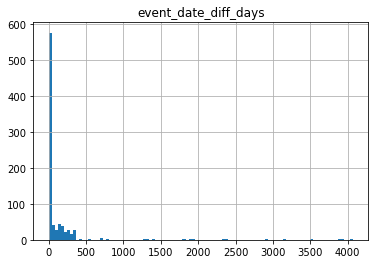

In [24]:
eved = ev.dropna(subset='event_date_diff_days')
eved.hist(column='event_date_diff_days', bins=100)

array([[<AxesSubplot:title={'center':'trr_time_of_day'}>]], dtype=object)

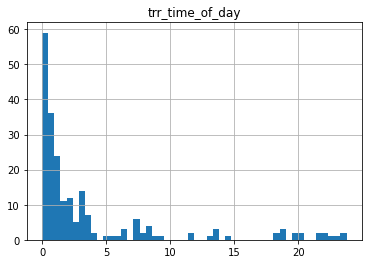

In [25]:
evtd = ev.dropna(subset='trr_datetime_diff_hours')
evtdf = evtd[evtd['event_date_diff_days']==1]
evtdf.hist(column='trr_time_of_day', bins=50)

### Experimenting with TRRs as Python classes

In [ ]:
def officer_trr_features(trr, uid):
    """Extracts officer-level features derived from TRRs officer has committed."""
    # charge (binary) / TRR ratio
    # TRR per year
    #

In [556]:
class event:
    """Event in which one or more officers used force (UoF) against one or more subjects."""
    
    def __init__(self, event_id, datetime):
        self.datetime = datetime
        self.event_id = event_id
        self.event_location = None#self.location()
        self.event_TRR = None
        
    def details(self):
        print(f'Event #{self.event_id}')
        print(f'Date/Time: {self.datetime}')
        if self.event_location != None:
            print('Location: ')
            print(self.event_location.details())
        
    class location:
        """Location of event, common across any and all TRRs (defined below)"""
        def __init__(self, beat, address, setting, in_or_out, light, weather):
            self.beat = beat
            self.address = address
            self.setting = setting
            self.indoor = self.whether_indoor(in_or_out)
            self.light = light
            self.weather = weather
            
        def details(self):
            print(f'Beat: {self.beat}') 
            print(f'Address: {self.address}')
            print(f'Setting: {self.in_or_out}, {self.setting.lower()} ')
            print(f'Light: {self.light.lower()}')
            print(f'Weather: {self.weather.lower()}')
            
        def whether_indoor(self, in_or_out):
            self.in_or_out = in_or_out
            if in_or_out == 'Outdoor':
                return(0)
            elif in_or_out == 'Indoor':
                return(1)
    class TRR:
        """A tactical response report (TRR) is a single instance of a use-of-force pairing between an officer and a subject.
       May be multiple TRRs in a single event, hence TRR class is nested under event class."""
    
        def __init__(self, trr_id, subject, officer):
            self.trr_id = trr_id
            self.subject = subject
            self.officer = officer
            
        class subject:
            def __init__(self, subject_id, gender, race, age, actions, charges):
                self.gender = gender
                self.race = race
                self.age = age
                self.actions = []
                self.charges = []
            
            def add_actions(self, action):
                for a in actions:
                    self.actions.append(a)
                    
            def add_charges(self, charges):
                for c in charges:
                    self.charges.append(c)
                
        class officer:
            def __init__(self, uid, assigned_beat, unit_detail, actions):
                self.uid = uid
                self.unit_detail = unit_detail
                self.assigned_beat = assigned_beat
                self.actions = []

In [557]:
e2 = event(event_id = trr.loc[8, 'event_id'], datetime=trr.loc[8, 'datetime'])
e2.event_location = e2.location(beat=trr.loc[0, 'beat'], address=trr.loc[0, 'address'], setting=trr.loc[0, 'location_recode'],\
                 in_or_out=trr.loc[0, 'indoor_or_outdoor'], light=trr.loc[0, 'lighting_condition'],\
                 weather=trr.loc[0, 'weather_condition'])
e2.event_TRR = e2.TRR(trr.loc[8, 'trr_id'], trr.loc[8, 'subject_ID'], trr.loc[8, 'UID'])
e2.event_TRR.subject(trr.loc[8, 'subject_ID'])

In [21]:
# Validation - DONT RUN
trr15 = main[main['datetime']>=pandas.to_datetime('1/1/2015')]
trr15 = trr15[trr15['datetime']<=pandas.to_datetime('12/31/2015')]
len(trr15) #5,373 vs. 6,455 per dashboard: https://home.chicagopolice.org/statistics-data/data-dashboards/use-of-force-dashboard/
# dashboard breaks down by location, subject demos, so we can narrow down which are missing from FOIA data